# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


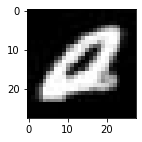

In [3]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

In [4]:
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import random
from torch.utils.tensorboard import SummaryWriter

Подготовим данные:

In [5]:
def get_data(path):
    X, y = [], []
    for root, dirs, files in os.walk(path):
        for filename in files:
            X.append(np.transpose(plt.imread(f"{path}/{filename[0]}/{filename}"), axes=(1, 0, 2)))
            y.append(ord(filename[0]) - ord('a'))
            
    return torch.tensor(X, dtype=torch.float), torch.tensor(y)

In [6]:
X, y = get_data("images/train")

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9)

In [8]:
X_test, y_test = get_data("images/test")

In [9]:
#Класс, унаследованный от torch.utils.data.Dataset, для преобразования данных
class LettersDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
train_dataset = LettersDataset(X_train, y_train)
val_dataset = LettersDataset(X_val, y_val)
test_dataset = LettersDataset(X_train, y_train)

### Задание 1  
  
*Вес в общей оценке - 0.35*  

**1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.** 

In [26]:
class TwoLayersFullyConnectedLettersModel(nn.Module):
    def __init__(self, num_inputs, num_outputs, activation=nn.ReLU(), hidden_size1=512, hidden_size2=128, hidden_size3=64):
        super(TwoLayersFullyConnectedLettersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(num_inputs, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, num_outputs)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.activation = activation
        
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.linear4(x)
    
        return x

In [14]:
class ThreeLayersFullyConnectedLettersModel(nn.Module):
    def __init__(self, num_inputs, num_outputs, activation=nn.ReLU(), hidden_size1=1024, hidden_size2=512, hidden_size3=128, hidden_size4=64):
        super(ThreeLayersFullyConnectedLettersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(num_inputs, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        self.linear5 = nn.Linear(hidden_size4, num_outputs)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.activation = activation
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.bn4(x)
        x = self.activation(x)
        x = self.linear5(x)
    
        return x

In [11]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            y_pred = model(imgs.permute(0, 3, 1, 2))
            loss = criterion(y_pred, labels) # вычисляем потрею
            loss.backward() # вычисляем градиент
            optimizer.step() # обновляем параметры сети
            optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
            
            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0) / labels.size(0)))
            pred_classes = torch.argmax(y_pred, dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels).sum().unsqueeze(0)
            ))
            
        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval() #
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                y_pred = model(imgs.permute(0, 3, 1, 2))
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0) / labels.size(0)))

                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels).sum().unsqueeze(0)
                ))
        train_losses.append(train_epoch_loss.mean().item())
        val_losses.append(val_epoch_loss.mean().item())
        train_acc.append(train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size)
        val_acc.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size) 
        
        print("    Train loss:", train_epoch_loss.mean().item())
        print("    Val loss:", val_epoch_loss.mean().item())
        print("    Train acc:", train_epoch_true_hits.sum().item() / train_epoch_true_hits.size(0) / train_dataloader.batch_size)
        print("    Val acc:", val_epoch_true_hits.sum().item() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        
    #print plot    
    x = np.linspace(0, 1, 100)
    plt.figure(figsize=(3, 3))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(range(n_epochs), train_losses, label="train loss")
    plt.plot(range(n_epochs), val_losses, label="val loss")
    plt.legend(fontsize=12)  
    plt.show()
    
    index_loss = np.argmax(val_epoch_loss)
    index_acc = np.argmax(val_acc)
    return {'loss': val_epoch_loss[index_loss], 'acc': val_acc[index_acc]}

Исследуем, при каком batch size удается получить более высокое значение accuracy и низкое значение loss:

batch size: 32


    Train loss: 0.03768271952867508
    Val loss: 0.018365679308772087
    Train acc: 0.7195359486057955
    Val acc: 0.8399203431372549


    Train loss: 0.01736229658126831
    Val loss: 0.013414896093308926
    Train acc: 0.8432886823400766
    Val acc: 0.8720894607843137


    Train loss: 0.013837490230798721
    Val loss: 0.01177377812564373
    Train acc: 0.8706431109896118
    Val acc: 0.8803615196078431


    Train loss: 0.011524803936481476
    Val loss: 0.011157810688018799
    Train acc: 0.8861228813559322
    Val acc: 0.8909313725490197


    Train loss: 0.010280560702085495
    Val loss: 0.010617459192872047
    Train acc: 0.8988689174412248
    Val acc: 0.8892463235294118


    Train loss: 0.00888731423765421
    Val loss: 0.009893746115267277
    Train acc: 0.9082319573537452
    Val acc: 0.8949142156862745


    Train loss: 0.008216270245611668
    Val loss: 0.010582029819488525
    Train acc: 0.9144512028430837
    Val acc: 0.8973651960784313


    Train loss: 0.007946392521262169
    Val loss: 0.009807297959923744
    Train acc: 0.9187226626571897
    Val acc: 0.8910845588235294


    Train loss: 0.007356136105954647
    Val loss: 0.009115027263760567
    Train acc: 0.922720749043193
    Val acc: 0.9021139705882353


    Train loss: 0.006944579072296619
    Val loss: 0.009388022124767303
    Train acc: 0.9273339256424276
    Val acc: 0.8995098039215687


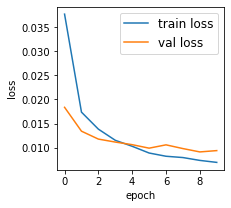

batch size: 64


    Train loss: 0.023986347019672394
    Val loss: 0.012491770088672638
    Train acc: 0.679474043715847
    Val acc: 0.8108149509803921


    Train loss: 0.01046802755445242
    Val loss: 0.007882378064095974
    Train acc: 0.8346311475409836
    Val acc: 0.8599877450980392


    Train loss: 0.007368096150457859
    Val loss: 0.006480433978140354
    Train acc: 0.8735143442622951
    Val acc: 0.8753063725490197


    Train loss: 0.006161285564303398
    Val loss: 0.005894031375646591
    Train acc: 0.894108606557377
    Val acc: 0.8875612745098039


    Train loss: 0.005198006052523851
    Val loss: 0.005346213933080435
    Train acc: 0.9056352459016394
    Val acc: 0.8927696078431373


    Train loss: 0.004640987142920494
    Val loss: 0.005107857286930084
    Train acc: 0.9158299180327869
    Val acc: 0.8958333333333334


    Train loss: 0.004257402382791042
    Val loss: 0.005100887268781662
    Train acc: 0.9205601092896175
    Val acc: 0.8979779411764706


    Train loss: 0.004361369181424379
    Val loss: 0.004960587713867426
    Train acc: 0.9274248633879781
    Val acc: 0.8962928921568627


    Train loss: 0.003961323294788599
    Val loss: 0.004971800372004509
    Train acc: 0.9332137978142077
    Val acc: 0.8975183823529411


    Train loss: 0.003875912167131901
    Val loss: 0.004984649829566479
    Train acc: 0.9321721311475409
    Val acc: 0.8979779411764706


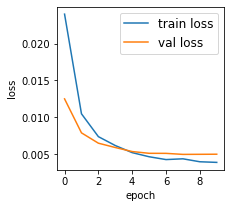

batch size: 128


    Train loss: 0.016141900792717934
    Val loss: 0.00962559413164854
    Train acc: 0.6118142740174672
    Val acc: 0.7598039215686274


    Train loss: 0.009143820963799953
    Val loss: 0.00582487927749753
    Train acc: 0.7932587336244541
    Val acc: 0.8189338235294118


    Train loss: 0.005793679039925337
    Val loss: 0.004439732991158962
    Train acc: 0.843732942139738
    Val acc: 0.8486519607843137


    Train loss: 0.004593717399984598
    Val loss: 0.0038085714913904667
    Train acc: 0.8721001637554585
    Val acc: 0.8658088235294118


    Train loss: 0.004077989142388105
    Val loss: 0.0035427678376436234
    Train acc: 0.8894309497816594
    Val acc: 0.8722426470588235


    Train loss: 0.004852657672017813
    Val loss: 0.003252100432291627
    Train acc: 0.8892774290393013
    Val acc: 0.8791360294117647


    Train loss: 0.003786233486607671
    Val loss: 0.003118135267868638
    Train acc: 0.9032648744541485
    Val acc: 0.8825061274509803


    Train loss: 0.002946993336081505
    Val loss: 0.002886777510866523
    Train acc: 0.9127661026200873
    Val acc: 0.8897058823529411


    Train loss: 0.0032142463605850935
    Val loss: 0.0027523082681000233
    Train acc: 0.9210391648471615
    Val acc: 0.8926164215686274


    Train loss: 0.0027452593203634024
    Val loss: 0.0028303060680627823
    Train acc: 0.9280499454148472
    Val acc: 0.8861825980392157


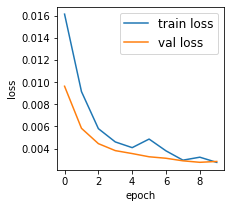

batch size: 256


    Train loss: 0.008980767801404
    Val loss: 0.007304899860173464
    Train acc: 0.5065502183406113
    Val acc: 0.6696213942307693


    Train loss: 0.005737231578677893
    Val loss: 0.0050099994987249374
    Train acc: 0.7279441866812227
    Val acc: 0.7472956730769231


    Train loss: 0.004060136619955301
    Val loss: 0.003673970466479659
    Train acc: 0.7924228984716157
    Val acc: 0.7893629807692307


    Train loss: 0.003068195190280676
    Val loss: 0.002986836712807417
    Train acc: 0.8328329694323144
    Val acc: 0.8162560096153846


    Train loss: 0.00245800893753767
    Val loss: 0.00247055571526289
    Train acc: 0.8584027019650655
    Val acc: 0.8308293269230769


    Train loss: 0.0020498232915997505
    Val loss: 0.0022494944278150797
    Train acc: 0.8772686954148472
    Val acc: 0.841796875


    Train loss: 0.0017614591633901
    Val loss: 0.0019791442900896072
    Train acc: 0.8914096615720524
    Val acc: 0.8487079326923077


    Train loss: 0.0015488818753510714
    Val loss: 0.0018585763173177838
    Train acc: 0.902292576419214
    Val acc: 0.8587740384615384


    Train loss: 0.0013782564783468843
    Val loss: 0.0017296232981607318
    Train acc: 0.9117255731441049
    Val acc: 0.8598257211538461


    Train loss: 0.0012400061823427677
    Val loss: 0.0016790602821856737
    Train acc: 0.9195380731441049
    Val acc: 0.8646334134615384


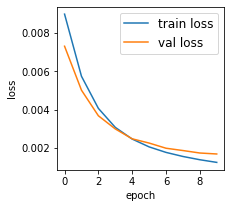

batch size: 512


    Train loss: 0.005115569569170475
    Val loss: 0.004343056585639715
    Train acc: 0.41623641304347825
    Val acc: 0.5815805288461539


    Train loss: 0.0038592179771512747
    Val loss: 0.0035217194817960262
    Train acc: 0.6407438858695652
    Val acc: 0.6729266826923077


    Train loss: 0.0031398492865264416
    Val loss: 0.002884050365537405
    Train acc: 0.7094599184782608
    Val acc: 0.7217548076923077


    Train loss: 0.0025922905188053846
    Val loss: 0.0024026543833315372
    Train acc: 0.7530400815217392
    Val acc: 0.7593149038461539


    Train loss: 0.0021584820933640003
    Val loss: 0.002047155052423477
    Train acc: 0.7865319293478261
    Val acc: 0.7833533653846154


    Train loss: 0.001833447371609509
    Val loss: 0.001751856878399849
    Train acc: 0.8134680706521739
    Val acc: 0.8019831730769231


    Train loss: 0.001588950166478753
    Val loss: 0.0015684898244217038
    Train acc: 0.831640625
    Val acc: 0.8167067307692307


    Train loss: 0.0013926223618909717
    Val loss: 0.0014028275618329644
    Train acc: 0.8475713315217391
    Val acc: 0.8273737980769231


    Train loss: 0.0012315157800912857
    Val loss: 0.0012869646307080984
    Train acc: 0.8611243206521739
    Val acc: 0.8356370192307693


    Train loss: 0.0011147318873554468
    Val loss: 0.0011713390704244375
    Train acc: 0.8723505434782609
    Val acc: 0.8435997596153846


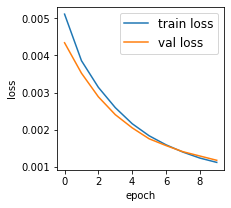

In [16]:
batch_sizes = [32, 64, 128, 256, 512]

criterion = nn.CrossEntropyLoss()

dict_metrics = {'loss':[], 'acc': []}
for i in range(len(batch_sizes)):
    model = TwoLayersFullyConnectedLettersModel(28*28*3, 26)
    print('batch size:', batch_sizes[i])
    train_dataloader = torch.utils.data.DataLoader(train_dataset,  batch_size=batch_sizes[i], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,  batch_size=batch_sizes[i], shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    metrics = (train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10))
    dict_metrics['loss'].append(metrics['loss'])
    dict_metrics['acc'].append(metrics['acc'])

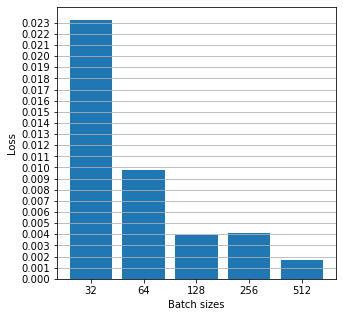

In [17]:
fig = plt.subplots(figsize =(5,5))
plt.bar(np.arange(len(batch_sizes)), dict_metrics['loss'], tick_label=batch_sizes)
plt.yticks(np.arange(0, np.max(dict_metrics['loss']), 0.001))
plt.xlabel('Batch sizes')
plt.ylabel('Loss')
plt.grid(axis = 'y')
plt.show()


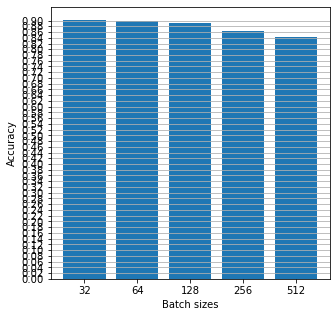

In [18]:
fig = plt.subplots(figsize =(5,5))
plt.bar(np.arange(len(batch_sizes)), dict_metrics['acc'], tick_label=batch_sizes)

plt.yticks(np.arange(0, np.max(dict_metrics['acc']), 0.02))

plt.xlabel('Batch sizes')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()


Самый высокий accuracy при batch_size = 32, поэтому тренировка будет производиться на нем.

In [30]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,  batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,  batch_size=32, shuffle=True)

Подберем лучший learning_rate на основе TwoLayersFullyConnectedLettersModel c batch_size = 32:

Learning rate is 0.1 :


    Train loss: 0.025882231071591377
    Val loss: 0.015496131964027882
    Train acc: 0.7447717331875342
    Val acc: 0.8432904411764706


    Train loss: 0.01595211960375309
    Val loss: 0.012284645810723305
    Train acc: 0.839478540185894
    Val acc: 0.8693321078431373


    Train loss: 0.013039345853030682
    Val loss: 0.01109825074672699
    Train acc: 0.8639625478403499
    Val acc: 0.8826593137254902


    Train loss: 0.011642850935459137
    Val loss: 0.012254567816853523
    Train acc: 0.8781950519409514
    Val acc: 0.8803615196078431


    Train loss: 0.010550854727625847
    Val loss: 0.011781861074268818
    Train acc: 0.889215418261345
    Val acc: 0.8880208333333334


    Train loss: 0.00992307998239994
    Val loss: 0.011062201112508774
    Train acc: 0.8943924275560415
    Val acc: 0.8897058823529411


    Train loss: 0.009334639646112919
    Val loss: 0.010822457261383533
    Train acc: 0.9002357845817387
    Val acc: 0.8881740196078431


    Train loss: 0.009024624712765217
    Val loss: 0.012887702323496342
    Train acc: 0.9008337889557135
    Val acc: 0.8881740196078431


    Train loss: 0.00838521122932434
    Val loss: 0.012462305836379528
    Train acc: 0.9098551120831055
    Val acc: 0.8926164215686274


    Train loss: 0.008521268144249916
    Val loss: 0.01084431353956461
    Train acc: 0.9068309185347184
    Val acc: 0.8918504901960784


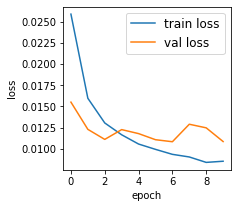

Learning rate is 0.01 :


    Train loss: 0.024352630600333214
    Val loss: 0.014002993702888489
    Train acc: 0.7681109896118097
    Val acc: 0.8503370098039216


    Train loss: 0.014051669277250767
    Val loss: 0.011843922547996044
    Train acc: 0.856598551120831
    Val acc: 0.8730085784313726


    Train loss: 0.011701197363436222
    Val loss: 0.010820631869137287
    Train acc: 0.8789980863860033
    Val acc: 0.8878676470588235


    Train loss: 0.01039173174649477
    Val loss: 0.0102610532194376
    Train acc: 0.8925300710770913
    Val acc: 0.8890931372549019


    Train loss: 0.00928435754030943
    Val loss: 0.010230320505797863
    Train acc: 0.9019272826681246
    Val acc: 0.8929227941176471


    Train loss: 0.008475829847157001
    Val loss: 0.010387481190264225
    Train acc: 0.9084369874248223
    Val acc: 0.8996629901960784


    Train loss: 0.007609673775732517
    Val loss: 0.011368622072041035
    Train acc: 0.9171507654455987
    Val acc: 0.8900122549019608


    Train loss: 0.0070530264638364315
    Val loss: 0.009941155090928078
    Train acc: 0.9203970749043193
    Val acc: 0.899203431372549


    Train loss: 0.006559266243129969
    Val loss: 0.009986412711441517
    Train acc: 0.92622334609076
    Val acc: 0.8990502450980392


    Train loss: 0.006317725870758295
    Val loss: 0.010063479654490948
    Train acc: 0.9284445051940952
    Val acc: 0.8990502450980392


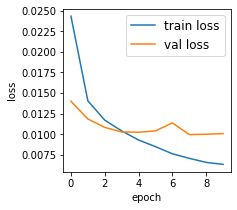

Learning rate is 0.001 :


    Train loss: 0.038252633064985275
    Val loss: 0.020078560337424278
    Train acc: 0.7160675232367414
    Val acc: 0.8373161764705882


    Train loss: 0.01737704686820507
    Val loss: 0.013545977883040905
    Train acc: 0.8410333515582286
    Val acc: 0.8659620098039216


    Train loss: 0.013540970161557198
    Val loss: 0.011946856044232845
    Train acc: 0.8705405959540733
    Val acc: 0.8769914215686274


    Train loss: 0.011275188066065311
    Val loss: 0.011418798007071018
    Train acc: 0.887165117550574
    Val acc: 0.8785232843137255


    Train loss: 0.010225052945315838
    Val loss: 0.010998954996466637
    Train acc: 0.8959643247676325
    Val acc: 0.8811274509803921


    Train loss: 0.00926706101745367
    Val loss: 0.010444078594446182
    Train acc: 0.9069846910880263
    Val acc: 0.8901654411764706


    Train loss: 0.008334929123520851
    Val loss: 0.010400042869150639
    Train acc: 0.9121958720612356
    Val acc: 0.8958333333333334


    Train loss: 0.007622993551194668
    Val loss: 0.010264388285577297
    Train acc: 0.9186714051394205
    Val acc: 0.8915441176470589


    Train loss: 0.007191114127635956
    Val loss: 0.00988901499658823
    Train acc: 0.924856478950246
    Val acc: 0.8972120098039216


    Train loss: 0.006776727735996246
    Val loss: 0.01068923156708479
    Train acc: 0.9275218698742482
    Val acc: 0.8946078431372549


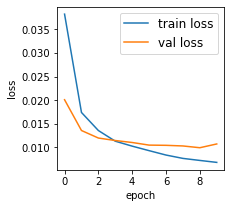

Learning rate is 0.0001 :


    Train loss: 0.07499846071004868
    Val loss: 0.06147100403904915
    Train acc: 0.48475943138326955
    Val acc: 0.6495098039215687


    Train loss: 0.05395830422639847
    Val loss: 0.04543735086917877
    Train acc: 0.6757278567523237
    Val acc: 0.7363664215686274


    Train loss: 0.04151114076375961
    Val loss: 0.03563397005200386
    Train acc: 0.7411837069436851
    Val acc: 0.7801776960784313


    Train loss: 0.033400170505046844
    Val loss: 0.028336048126220703
    Train acc: 0.7793705576817933
    Val acc: 0.8097426470588235


    Train loss: 0.027658628299832344
    Val loss: 0.02410225383937359
    Train acc: 0.8090828321487151
    Val acc: 0.8302696078431373


    Train loss: 0.023772720247507095
    Val loss: 0.020757850259542465
    Train acc: 0.8277747402952433
    Val acc: 0.8393075980392157


    Train loss: 0.021058332175016403
    Val loss: 0.019040042534470558
    Train acc: 0.8442454893384364
    Val acc: 0.8492647058823529


    Train loss: 0.018845342099666595
    Val loss: 0.017315739765763283
    Train acc: 0.8541381902679059
    Val acc: 0.8570772058823529


    Train loss: 0.017103150486946106
    Val loss: 0.01625712960958481
    Train acc: 0.8652098141060689
    Val acc: 0.8616727941176471


    Train loss: 0.015996640548110008
    Val loss: 0.01578560471534729
    Train acc: 0.8740944505194095
    Val acc: 0.8667279411764706


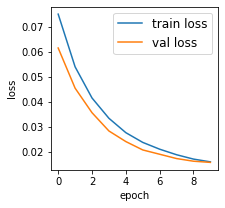

In [65]:
criterion = nn.CrossEntropyLoss()

for lr in [0.1, 0.01, 0.001, 0.0001]:
    lr_model = TwoLayersFullyConnectedLettersModel(28*28*3, 26)
    print("Learning rate is", lr, ":")
    optimizer = optim.SGD(lr_model.parameters(), lr=lr, momentum=0.9)
    train(lr_model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10)

В дальнейшем будет использоваться **learning rate = 0.001**, так как при нем достигается наилучшее качество за оптимальное время.

Тренировка моделей TwoLayersFullyConnectedLettersModel и ThreeLayersFullyConnectedLettersModel c подобранным learning rate:

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.0377943329513073
    Val loss: 0.01913890801370144
    Train acc: 0.7197409786768726
    Val acc: 0.8342524509803921


    Train loss: 0.017232710495591164
    Val loss: 0.014140679500997066
    Train acc: 0.8432203389830508
    Val acc: 0.8685661764705882


    Train loss: 0.013459245674312115
    Val loss: 0.013028200715780258
    Train acc: 0.8694983597594313
    Val acc: 0.8760723039215687


    Train loss: 0.011372193694114685
    Val loss: 0.01202393788844347
    Train acc: 0.8891129032258065
    Val acc: 0.8844975490196079


    Train loss: 0.010245519690215588
    Val loss: 0.010580644942820072
    Train acc: 0.8964939857845817
    Val acc: 0.8893995098039216


    Train loss: 0.009142663329839706
    Val loss: 0.010840323753654957
    Train acc: 0.9073605795516676
    Val acc: 0.8875612745098039


    Train loss: 0.008777277544140816
    Val loss: 0.011039052158594131
    Train acc: 0.9116832968835429
    Val acc: 0.8887867647058824


    Train loss: 0.007839991711080074
    Val loss: 0.010166686959564686
    Train acc: 0.9197307271733187
    Val acc: 0.8926164215686274


    Train loss: 0.007261549588292837
    Val loss: 0.010891645215451717
    Train acc: 0.9234725259704757
    Val acc: 0.8962928921568627


    Train loss: 0.007052334025502205
    Val loss: 0.009719419293105602
    Train acc: 0.926787178786222
    Val acc: 0.897671568627451


    Train loss: 0.006805202923715115
    Val loss: 0.009857735596597195
    Train acc: 0.9301360032804812
    Val acc: 0.8970588235294118


    Train loss: 0.006435869727283716
    Val loss: 0.01006063912063837
    Train acc: 0.9295379989065062
    Val acc: 0.891390931372549


    Train loss: 0.00578912440687418
    Val loss: 0.009457889012992382
    Train acc: 0.9359622744669218
    Val acc: 0.9047181372549019


    Train loss: 0.005534927360713482
    Val loss: 0.00971098244190216
    Train acc: 0.9403704209950793
    Val acc: 0.8973651960784313


    Train loss: 0.005310046020895243
    Val loss: 0.011643067002296448
    Train acc: 0.9408317386550027
    Val acc: 0.8995098039215687


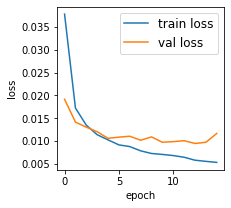

ThreeLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.03564837574958801
    Val loss: 0.016550377011299133
    Train acc: 0.7381424275560415
    Val acc: 0.8514093137254902


    Train loss: 0.015995947644114494
    Val loss: 0.012545467354357243
    Train acc: 0.8542407053034445
    Val acc: 0.8797487745098039


    Train loss: 0.012345119379460812
    Val loss: 0.010634275153279305
    Train acc: 0.8836454346637507
    Val acc: 0.8883272058823529


    Train loss: 0.010147790424525738
    Val loss: 0.011291380040347576
    Train acc: 0.9014830508474576
    Val acc: 0.8886335784313726


    Train loss: 0.008772574365139008
    Val loss: 0.010293599218130112
    Train acc: 0.9123496446145435
    Val acc: 0.8880208333333334


    Train loss: 0.007801033090800047
    Val loss: 0.010540145449340343
    Train acc: 0.9177145981410607
    Val acc: 0.8941482843137255


    Train loss: 0.007263069041073322
    Val loss: 0.009699258953332901
    Train acc: 0.9260183160196829
    Val acc: 0.8978247549019608


    Train loss: 0.006979550700634718
    Val loss: 0.010984770022332668
    Train acc: 0.9291962821213778
    Val acc: 0.890625


    Train loss: 0.006254930514842272
    Val loss: 0.010044390335679054
    Train acc: 0.9329380809185347
    Val acc: 0.897671568627451


    Train loss: 0.005368941463530064
    Val loss: 0.009126491844654083
    Train acc: 0.9416006014215418
    Val acc: 0.9013480392156863


    Train loss: 0.004869685973972082
    Val loss: 0.010260503739118576
    Train acc: 0.94595749043193
    Val acc: 0.8969056372549019


    Train loss: 0.00467300321906805
    Val loss: 0.00946466252207756
    Train acc: 0.9478540185893931
    Val acc: 0.9004289215686274


    Train loss: 0.004827086813747883
    Val loss: 0.009848034009337425
    Train acc: 0.9473927009294697
    Val acc: 0.9045649509803921


    Train loss: 0.004804829601198435
    Val loss: 0.010395827703177929
    Train acc: 0.9458037178786222
    Val acc: 0.8961397058823529


    Train loss: 0.004093715455383062
    Val loss: 0.00982877891510725
    Train acc: 0.9519546200109349
    Val acc: 0.9021139705882353


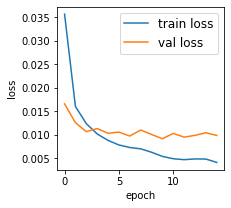

In [66]:
models = [TwoLayersFullyConnectedLettersModel(28*28*3, 26), ThreeLayersFullyConnectedLettersModel(28*28*3, 26)]
for model in models:
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=15)

Подбор лучших пареметров модели для TwoLayersFullyConnectedLettersModel c batch_size = 32 и learning_rate = 0.001:

1. Добавление слоя dropout для того, чтобы параметры модели не подстраивались под тренировочную выборку.

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


    Train loss: 0.00531105836853385
    Val loss: 0.00437207194045186
    Train acc: 0.30343070652173915
    Val acc: 0.5829326923076923


    Train loss: 0.004119879566133022
    Val loss: 0.0035626052413135767
    Train acc: 0.5457201086956521
    Val acc: 0.6802884615384616


    Train loss: 0.0035027149133384228
    Val loss: 0.002987775020301342
    Train acc: 0.6252207880434782
    Val acc: 0.7225060096153846


    Train loss: 0.003030226333066821
    Val loss: 0.002521488582715392
    Train acc: 0.6794157608695652
    Val acc: 0.7555588942307693


    Train loss: 0.002695406088605523
    Val loss: 0.0021862140856683254
    Train acc: 0.7080672554347827
    Val acc: 0.7785456730769231


    Train loss: 0.002414996735751629
    Val loss: 0.0019167731516063213
    Train acc: 0.7355978260869566
    Val acc: 0.7917668269230769


    Train loss: 0.002198179019615054
    Val loss: 0.0017251861281692982
    Train acc: 0.755757472826087
    Val acc: 0.8102463942307693


    Train loss: 0.002016349695622921
    Val loss: 0.0015399705152958632
    Train acc: 0.7703125
    Val acc: 0.8159555288461539


    Train loss: 0.0018551754765212536
    Val loss: 0.0013990954030305147
    Train acc: 0.7829144021739131
    Val acc: 0.8278245192307693


    Train loss: 0.0017243254696950316
    Val loss: 0.001293876557610929
    Train acc: 0.7963315217391305
    Val acc: 0.833984375


    Train loss: 0.001620550057850778
    Val loss: 0.0012136553414165974
    Train acc: 0.8059782608695653
    Val acc: 0.8381911057692307


    Train loss: 0.0015175457810983062
    Val loss: 0.0011364298406988382
    Train acc: 0.8156929347826087
    Val acc: 0.8451021634615384


    Train loss: 0.0014415879268199205
    Val loss: 0.0010688933543860912
    Train acc: 0.8240998641304348
    Val acc: 0.8505108173076923


    Train loss: 0.0013698004186153412
    Val loss: 0.0010167025029659271
    Train acc: 0.8296705163043478
    Val acc: 0.8527644230769231


    Train loss: 0.0012998366728425026
    Val loss: 0.0009664364624768496
    Train acc: 0.8376868206521739
    Val acc: 0.8541165865384616


    Train loss: 0.0012465864419937134
    Val loss: 0.0009310230962000787
    Train acc: 0.8430706521739131
    Val acc: 0.8583233173076923


    Train loss: 0.0011929195607081056
    Val loss: 0.0009095871355384588
    Train acc: 0.848828125
    Val acc: 0.8580228365384616


    Train loss: 0.0011421887902542949
    Val loss: 0.0008757410105317831
    Train acc: 0.853125
    Val acc: 0.8626802884615384


    Train loss: 0.0011035390198230743
    Val loss: 0.0008558130939491093
    Train acc: 0.8561990489130434
    Val acc: 0.8634314903846154


    Train loss: 0.0010662793647497892
    Val loss: 0.0008360206265933812
    Train acc: 0.862890625
    Val acc: 0.865234375


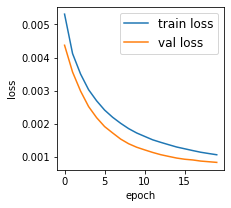

{'loss': tensor(0.0013), 'acc': tensor(0.8652)}

In [21]:
one_dropout_model = TwoLayersFullyConnectedLettersModel(28*28*3, 26)
optimizer = optim.SGD(one_dropout_model.parameters(), lr=0.001, momentum=0.9)
print(one_dropout_model)
train(one_dropout_model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=20)

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


    Train loss: 0.00598341878503561
    Val loss: 0.005218240898102522
    Train acc: 0.1680366847826087
    Val acc: 0.4756610576923077


    Train loss: 0.005179065745323896
    Val loss: 0.004656430799514055
    Train acc: 0.3248811141304348
    Val acc: 0.5393629807692307


    Train loss: 0.0047143069095909595
    Val loss: 0.004184032790362835
    Train acc: 0.39814877717391306
    Val acc: 0.5884915865384616


    Train loss: 0.004355772864073515
    Val loss: 0.0037692836485803127
    Train acc: 0.44668817934782606
    Val acc: 0.6319110576923077


    Train loss: 0.004030273761600256
    Val loss: 0.0034094227012246847
    Train acc: 0.4881623641304348
    Val acc: 0.6666165865384616


    Train loss: 0.0037592619191855192
    Val loss: 0.003094661980867386
    Train acc: 0.5217900815217391
    Val acc: 0.705078125


    Train loss: 0.0035023759119212627
    Val loss: 0.00280062947422266
    Train acc: 0.5535665760869565
    Val acc: 0.7274639423076923


    Train loss: 0.0032849879935383797
    Val loss: 0.002518362132832408
    Train acc: 0.5782099184782609
    Val acc: 0.7475961538461539


    Train loss: 0.003065812401473522
    Val loss: 0.002297762082889676
    Train acc: 0.602734375
    Val acc: 0.7606670673076923


    Train loss: 0.00290978723205626
    Val loss: 0.0021186391822993755
    Train acc: 0.6220788043478261
    Val acc: 0.7731370192307693


    Train loss: 0.0027432444039732218
    Val loss: 0.0019520034547895193
    Train acc: 0.641219429347826
    Val acc: 0.7794471153846154


    Train loss: 0.002607186557725072
    Val loss: 0.0017947203014045954
    Train acc: 0.6545686141304348
    Val acc: 0.7902644230769231


    Train loss: 0.00248575652949512
    Val loss: 0.0016819017473608255
    Train acc: 0.6639436141304348
    Val acc: 0.7986778846153846


    Train loss: 0.002384661231189966
    Val loss: 0.0015721657546237111
    Train acc: 0.6757642663043478
    Val acc: 0.8034855769230769


    Train loss: 0.002303842920809984
    Val loss: 0.001476868987083435
    Train acc: 0.6874490489130435
    Val acc: 0.8126502403846154


    Train loss: 0.0021959112491458654
    Val loss: 0.001426780829206109
    Train acc: 0.6964334239130435
    Val acc: 0.8159555288461539


    Train loss: 0.002137848874554038
    Val loss: 0.0013445469085127115
    Train acc: 0.7057744565217391
    Val acc: 0.8225661057692307


    Train loss: 0.0020577204413712025
    Val loss: 0.0012707081623375416
    Train acc: 0.7145889945652174
    Val acc: 0.8258713942307693


    Train loss: 0.002002765890210867
    Val loss: 0.001219340949319303
    Train acc: 0.7205842391304348
    Val acc: 0.8296274038461539


    Train loss: 0.0019380676094442606
    Val loss: 0.0011702134506776929
    Train acc: 0.729110054347826
    Val acc: 0.8282752403846154


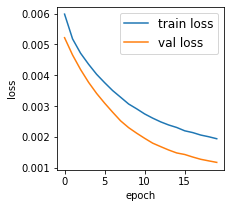

{'loss': tensor(0.0015), 'acc': tensor(0.8296)}

In [24]:
two_dropout_model = TwoLayersFullyConnectedLettersModel(28*28*3, 26)
optimizer = optim.SGD(two_dropout_model.parameters(), lr=0.001, momentum=0.9)
print(two_dropout_model)
train(two_dropout_model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=20)

DropOut ухудшает качество полносвязных моделей, поэтому в дальнейшем он не будет использоваться.

2. Изменение числа нейронов в слоях:

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.00513891177251935
    Val loss: 0.00436593871563673
    Train acc: 0.4076766304347826
    Val acc: 0.5859375


    Train loss: 0.0038777755107730627
    Val loss: 0.003530439455062151
    Train acc: 0.6471467391304347
    Val acc: 0.6723257211538461


    Train loss: 0.003152091521769762
    Val loss: 0.0029144713189452887
    Train acc: 0.7112092391304348
    Val acc: 0.7208533653846154


    Train loss: 0.0026079327799379826
    Val loss: 0.0024190456606447697
    Train acc: 0.7530910326086957
    Val acc: 0.7527043269230769


    Train loss: 0.0021913175005465746
    Val loss: 0.002059351187199354
    Train acc: 0.7857676630434782
    Val acc: 0.7764423076923077


    Train loss: 0.0018653490114957094
    Val loss: 0.001788754598237574
    Train acc: 0.8118036684782609
    Val acc: 0.7983774038461539


    Train loss: 0.0016096591716632247
    Val loss: 0.0015727696008980274
    Train acc: 0.8290760869565217
    Val acc: 0.80859375


    Train loss: 0.00141822115983814
    Val loss: 0.0014121673302724957
    Train acc: 0.8449898097826087
    Val acc: 0.8210637019230769


    Train loss: 0.0012649759883061051
    Val loss: 0.0012999559985473752
    Train acc: 0.8576426630434782
    Val acc: 0.8270733173076923


    Train loss: 0.0011409578146412969
    Val loss: 0.001204341766424477
    Train acc: 0.8677479619565217
    Val acc: 0.8381911057692307


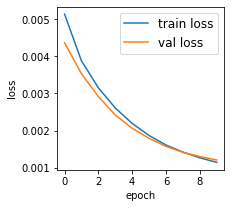

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=26, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.005093101877719164
    Val loss: 0.004483011085540056
    Train acc: 0.4512907608695652
    Val acc: 0.6143329326923077


    Train loss: 0.004058436024934053
    Val loss: 0.0037656943313777447
    Train acc: 0.6793817934782609
    Val acc: 0.7037259615384616


    Train loss: 0.003380553098395467
    Val loss: 0.0031333481892943382
    Train acc: 0.7461616847826087
    Val acc: 0.7510516826923077


    Train loss: 0.002811441197991371
    Val loss: 0.0026127661112695932
    Train acc: 0.7907269021739131
    Val acc: 0.7810997596153846


    Train loss: 0.00232732854783535
    Val loss: 0.002209440805017948
    Train acc: 0.8227751358695652
    Val acc: 0.8015324519230769


    Train loss: 0.001933566527441144
    Val loss: 0.0018856649985536933
    Train acc: 0.8470448369565218
    Val acc: 0.8180588942307693


    Train loss: 0.0016258250689134002
    Val loss: 0.0016174123156815767
    Train acc: 0.8662703804347827
    Val acc: 0.8318810096153846


    Train loss: 0.0013794248225167394
    Val loss: 0.0014415718615055084
    Train acc: 0.8815217391304347
    Val acc: 0.8425480769230769


    Train loss: 0.0011908008018508554
    Val loss: 0.0012925000628456473
    Train acc: 0.8943104619565218
    Val acc: 0.8493088942307693


    Train loss: 0.0010323808528482914
    Val loss: 0.0011866516433656216
    Train acc: 0.9061650815217391
    Val acc: 0.8566706730769231


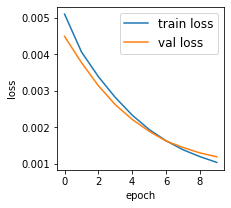

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=26, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.0055166566744446754
    Val loss: 0.004963191691786051
    Train acc: 0.3436990489130435
    Val acc: 0.5091646634615384


    Train loss: 0.004581080749630928
    Val loss: 0.004310667049139738
    Train acc: 0.5737432065217392
    Val acc: 0.5990084134615384


    Train loss: 0.003984743729233742
    Val loss: 0.0037663651164621115
    Train acc: 0.6379925271739131
    Val acc: 0.6530949519230769


    Train loss: 0.003470567287877202
    Val loss: 0.003251135814934969
    Train acc: 0.686430027173913
    Val acc: 0.697265625


    Train loss: 0.0029901652596890926
    Val loss: 0.0028122784569859505
    Train acc: 0.7273777173913043
    Val acc: 0.728515625


    Train loss: 0.0025807779747992754
    Val loss: 0.0024533295072615147
    Train acc: 0.7594938858695652
    Val acc: 0.7552584134615384


    Train loss: 0.0022384687326848507
    Val loss: 0.002140372060239315
    Train acc: 0.7872452445652174
    Val acc: 0.7777944711538461


    Train loss: 0.0019673092756420374
    Val loss: 0.0018890107749029994
    Train acc: 0.8079313858695653
    Val acc: 0.7922175480769231


    Train loss: 0.0017312150448560715
    Val loss: 0.001714210258796811
    Train acc: 0.824711277173913
    Val acc: 0.8042367788461539


    Train loss: 0.0015428329352289438
    Val loss: 0.0015475801192224026
    Train acc: 0.8377717391304348
    Val acc: 0.8131009615384616


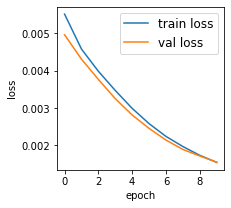

In [28]:
parametrs = [[512, 128, 64], [2048, 512, 32], [256, 64, 32]]
models = [TwoLayersFullyConnectedLettersModel]
models = [model(28*28*3, 26, hidden_size1=hs[0], hidden_size2=hs[1], hidden_size3=hs[2]) 
          for model in models
          for hs in parametrs]

num_neurons_metrics = {'loss': [], 'acc': []}
for i in range(len(models)):
    optimizer = optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9)
    print(models[i])
    metrics = train(models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10)
    num_neurons_metrics['loss'].append(metrics['loss'])
    num_neurons_metrics['acc'].append(metrics['acc'])

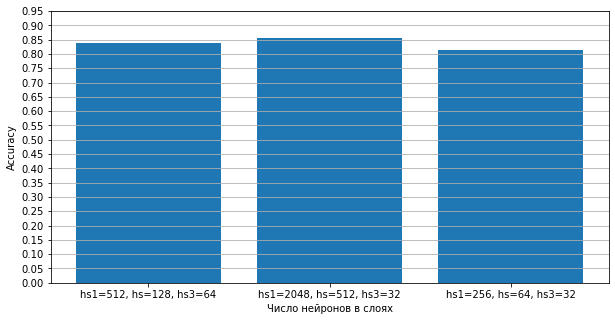

In [34]:
fig = plt.subplots(figsize =(10, 5))
plt.bar(np.arange(3), num_neurons_metrics['acc'], tick_label=['hs1=512, hs=128, hs3=64','hs1=2048, hs=512, hs3=32', 'hs1=256, hs=64, hs3=32'])

plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel('Число нейронов в слоях')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()

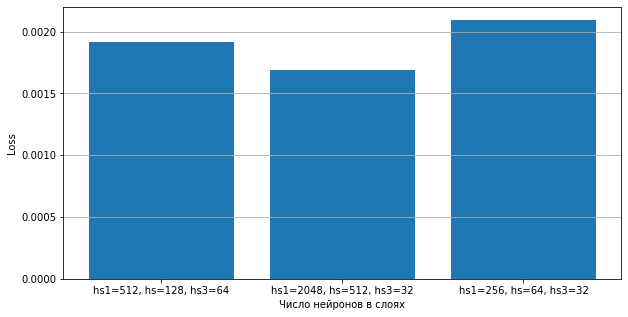

In [35]:
fig = plt.subplots(figsize =(10,5))
plt.bar(np.arange(3), num_neurons_metrics['loss'], tick_label=['hs1=512, hs=128, hs3=64','hs1=2048, hs=512, hs3=32', 'hs1=256, hs=64, hs3=32'])

plt.yticks(np.arange(0, np.max(num_neurons_metrics['loss']), 0.0005))

plt.xlabel('Число нейронов в слоях')
plt.ylabel('Loss')

plt.grid(axis = 'y')
plt.show()

Лучшие показатели у мдели с параметрами hs1=2048, hs=512, hs3=32.

3. Изменение функции активации:

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.005121429916471243
    Val loss: 0.004338188096880913
    Train acc: 0.40998641304347827
    Val acc: 0.5802283653846154


    Train loss: 0.0038253164384514093
    Val loss: 0.0034740837290883064
    Train acc: 0.6450067934782608
    Val acc: 0.6849459134615384


    Train loss: 0.003076152643188834
    Val loss: 0.002808947581797838
    Train acc: 0.7155061141304347
    Val acc: 0.7315204326923077


    Train loss: 0.0025103522930294275
    Val loss: 0.00233561173081398
    Train acc: 0.7607336956521739
    Val acc: 0.7669771634615384


    Train loss: 0.0020808319095522165
    Val loss: 0.001994987716898322
    Train acc: 0.7934782608695652
    Val acc: 0.7845552884615384


    Train loss: 0.0017724082572385669
    Val loss: 0.0017127834726125002
    Train acc: 0.8171025815217391
    Val acc: 0.7994290865384616


    Train loss: 0.0015290308510884643
    Val loss: 0.0015436733374372125
    Train acc: 0.8353940217391305
    Val acc: 0.8103966346153846


    Train loss: 0.001344106625765562
    Val loss: 0.001396502135321498
    Train acc: 0.8505434782608695
    Val acc: 0.8234675480769231


    Train loss: 0.0012052537640556693
    Val loss: 0.0012805816950276494
    Train acc: 0.8631283967391304
    Val acc: 0.8290264423076923


    Train loss: 0.0010835238499566913
    Val loss: 0.0011956922244280577
    Train acc: 0.8732676630434782
    Val acc: 0.8360877403846154


    Train loss: 0.0009899934520944953
    Val loss: 0.001144757610745728
    Train acc: 0.8832880434782608
    Val acc: 0.8383413461538461


    Train loss: 0.0009086568607017398
    Val loss: 0.0010779016884043813
    Train acc: 0.8904211956521739
    Val acc: 0.8428485576923077


    Train loss: 0.0008403056999668479
    Val loss: 0.0010292342631146312
    Train acc: 0.8974354619565217
    Val acc: 0.8475060096153846


    Train loss: 0.0007763704052194953
    Val loss: 0.0009933545952662826
    Train acc: 0.9039911684782609
    Val acc: 0.8497596153846154


    Train loss: 0.0007265708991326392
    Val loss: 0.0009533498086966574
    Train acc: 0.9093580163043479
    Val acc: 0.8520132211538461


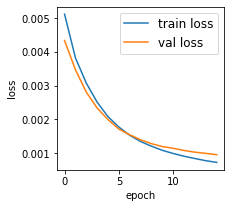

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): Tanh()
)


    Train loss: 0.004972656257450581
    Val loss: 0.004337090067565441
    Train acc: 0.43882472826086955
    Val acc: 0.5614483173076923


    Train loss: 0.003968232776969671
    Val loss: 0.003716481616720557
    Train acc: 0.6085427989130435
    Val acc: 0.6284555288461539


    Train loss: 0.0034374152310192585
    Val loss: 0.0032715201377868652
    Train acc: 0.6626358695652174
    Val acc: 0.6714242788461539


    Train loss: 0.0030295029282569885
    Val loss: 0.002909002359956503
    Train acc: 0.7018682065217391
    Val acc: 0.7067307692307693


    Train loss: 0.0026738569140434265
    Val loss: 0.0025927098467946053
    Train acc: 0.7326596467391304
    Val acc: 0.7307692307692307


    Train loss: 0.0023759386967867613
    Val loss: 0.0023196195252239704
    Train acc: 0.7607846467391305
    Val acc: 0.7510516826923077


    Train loss: 0.002129640895873308
    Val loss: 0.00211486779153347
    Train acc: 0.7824898097826087
    Val acc: 0.7672776442307693


    Train loss: 0.0019122568191960454
    Val loss: 0.0019221180118620396
    Train acc: 0.8034986413043478
    Val acc: 0.7839543269230769


    Train loss: 0.0017217152053490281
    Val loss: 0.0017767074750736356
    Train acc: 0.8186990489130435
    Val acc: 0.7961237980769231


    Train loss: 0.0015737544745206833
    Val loss: 0.0016469541005790234
    Train acc: 0.8333389945652174
    Val acc: 0.8022836538461539


    Train loss: 0.0014416862977668643
    Val loss: 0.0015403933357447386
    Train acc: 0.8443614130434782
    Val acc: 0.8097956730769231


    Train loss: 0.0013233479112386703
    Val loss: 0.0014519754331558943
    Train acc: 0.8558084239130435
    Val acc: 0.81640625


    Train loss: 0.0012302881805226207
    Val loss: 0.001387036289088428
    Train acc: 0.865132472826087
    Val acc: 0.8227163461538461


    Train loss: 0.0011422168463468552
    Val loss: 0.0013341364683583379
    Train acc: 0.8733865489130435
    Val acc: 0.8224158653846154


    Train loss: 0.0010672997450456023
    Val loss: 0.0012662187218666077
    Train acc: 0.8802139945652174
    Val acc: 0.8303786057692307


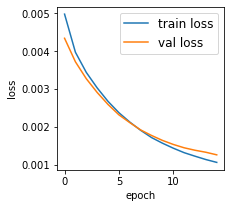

TwoLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.01)
)


    Train loss: 0.005135480780154467
    Val loss: 0.0043333545327186584
    Train acc: 0.4024626358695652
    Val acc: 0.5740685096153846


    Train loss: 0.0038556945510208607
    Val loss: 0.003470319090411067
    Train acc: 0.6389775815217391
    Val acc: 0.6756310096153846


    Train loss: 0.0031106348615139723
    Val loss: 0.002860704669728875
    Train acc: 0.7119395380434783
    Val acc: 0.7205528846153846


    Train loss: 0.0025519724003970623
    Val loss: 0.002388707594946027
    Train acc: 0.7570822010869566
    Val acc: 0.7521033653846154


    Train loss: 0.002135667484253645
    Val loss: 0.002052359515801072
    Train acc: 0.789164402173913
    Val acc: 0.7768930288461539


    Train loss: 0.001828791224397719
    Val loss: 0.0017720268806442618
    Train acc: 0.8143002717391304
    Val acc: 0.7919170673076923


    Train loss: 0.0015683394158259034
    Val loss: 0.0015838330145925283
    Train acc: 0.8326766304347826
    Val acc: 0.8058894230769231


    Train loss: 0.0013862362829968333
    Val loss: 0.0014353274600580335
    Train acc: 0.8491508152173913
    Val acc: 0.8141526442307693


    Train loss: 0.0012286655837669969
    Val loss: 0.0013215653598308563
    Train acc: 0.8626698369565218
    Val acc: 0.8212139423076923


    Train loss: 0.0011026595020666718
    Val loss: 0.0012146574445068836
    Train acc: 0.8731997282608696
    Val acc: 0.8330829326923077


    Train loss: 0.001000717282295227
    Val loss: 0.0011356379836797714
    Train acc: 0.8820652173913044
    Val acc: 0.8359375


    Train loss: 0.0009197057806886733
    Val loss: 0.001086670090444386
    Train acc: 0.8906419836956522
    Val acc: 0.8420973557692307


    Train loss: 0.0008439634111709893
    Val loss: 0.0010273292427882552
    Train acc: 0.8968919836956522
    Val acc: 0.8460036057692307


    Train loss: 0.0007837447919882834
    Val loss: 0.0009803699795156717
    Train acc: 0.9039911684782609
    Val acc: 0.8505108173076923


    Train loss: 0.0007335411501117051
    Val loss: 0.0009585708612576127
    Train acc: 0.9096976902173913
    Val acc: 0.8500600961538461


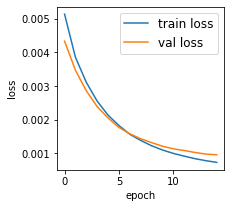

In [50]:
activations = [nn.ReLU(), nn.Tanh(), nn.LeakyReLU()]
models = [TwoLayersFullyConnectedLettersModel(28*28*3, 26, activation=act) for act in activations]

activations_metrics = {'loss': [], 'acc': []}
for i in range(len(models)):
    optimizer = optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9)
    print(models[i])
    metrics = train(models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=15)
    activations_metrics['loss'].append(metrics['loss'])
    activations_metrics['acc'].append(metrics['acc'])

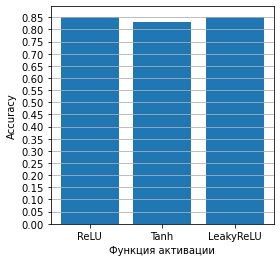

In [57]:
fig = plt.subplots(figsize =(4,4))
plt.bar(np.arange(3), activations_metrics['acc'], tick_label=['ReLU', 'Tanh', 'LeakyReLU'])

plt.yticks(np.arange(0, np.max(activations_metrics['acc']), 0.05))

plt.xlabel('Функция активации')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()

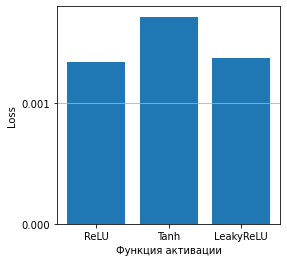

In [55]:
fig = plt.subplots(figsize =(4,4))
plt.bar(np.arange(3), activations_metrics['loss'], tick_label=['ReLU', 'Tanh', 'LeakyReLU'])

plt.yticks(np.arange(0, np.max(activations_metrics['loss']), 0.001))

plt.xlabel('Функция активации')
plt.ylabel('Loss')

plt.grid(axis = 'y')
plt.show()

 В дальнейшем будет использоваться **ReLU**, поскольку модель, использовавшая эту функцию активации показала низкий loss и высокий accuracy.

#### Тренировка TwoLayersFullyConnectedLettersModel c лучшими параметрами:
* batch size = 32
* learning rate = 0.001
* число нейронов в слоях - hs1=1024, hs=512, hs3=32 
* функция активации - ReLU

    Train loss: 0.005134371109306812
    Val loss: 0.004348461516201496
    Train acc: 0.41779891304347827
    Val acc: 0.5821814903846154


    Train loss: 0.003840100485831499
    Val loss: 0.0034770281054079533
    Train acc: 0.6418138586956522
    Val acc: 0.6709735576923077


    Train loss: 0.0030970764346420765
    Val loss: 0.0028515979647636414
    Train acc: 0.7137228260869565
    Val acc: 0.7216045673076923


    Train loss: 0.0025448959786444902
    Val loss: 0.002369545865803957
    Train acc: 0.7593410326086957
    Val acc: 0.7530048076923077


    Train loss: 0.0021226040553301573
    Val loss: 0.0020293823909014463
    Train acc: 0.7907269021739131
    Val acc: 0.7800480769230769


    Train loss: 0.0018068605568259954
    Val loss: 0.0017519255634397268
    Train acc: 0.8159307065217392
    Val acc: 0.794921875


    Train loss: 0.0015631617279723287
    Val loss: 0.0015693579334765673
    Train acc: 0.834578804347826
    Val acc: 0.8097956730769231


    Train loss: 0.0013759215362370014
    Val loss: 0.0014203987084329128
    Train acc: 0.8481997282608695
    Val acc: 0.8195612980769231


    Train loss: 0.0012323546689003706
    Val loss: 0.0012849490158259869
    Train acc: 0.8613451086956522
    Val acc: 0.8299278846153846


    Train loss: 0.001110027194954455
    Val loss: 0.0012150469701737165
    Train acc: 0.8728940217391304
    Val acc: 0.8368389423076923


    Train loss: 0.001012430409900844
    Val loss: 0.0011301384074613452
    Train acc: 0.8819633152173914
    Val acc: 0.8422475961538461


    Train loss: 0.0009251331794075668
    Val loss: 0.0010808518854901195
    Train acc: 0.8900135869565218
    Val acc: 0.8464543269230769


    Train loss: 0.0008498207316733897
    Val loss: 0.001031441381201148
    Train acc: 0.897944972826087
    Val acc: 0.8485576923076923


    Train loss: 0.0007935011526569724
    Val loss: 0.0009885680628940463
    Train acc: 0.9041610054347826
    Val acc: 0.8506610576923077


    Train loss: 0.0007337791612371802
    Val loss: 0.0009498639265075326
    Train acc: 0.9095278532608696
    Val acc: 0.8547175480769231


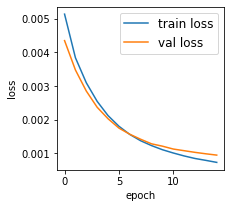

{'loss': tensor(0.0013), 'acc': tensor(0.8547)}

In [18]:
criterion = nn.CrossEntropyLoss()
best_2l_model = TwoLayersFullyConnectedLettersModel(28*28*3, 26)
optimizer = optim.SGD(best_2l_model.parameters(), lr=0.001, momentum=0.9)
train(best_2l_model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=15)

#### Подбор числа параметров сети для ThreeLayersFullyConnectedLettersModel:

ThreeLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=26, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.004806426353752613
    Val loss: 0.0037711148615926504
    Train acc: 0.4578294836956522
    Val acc: 0.6371694711538461


    Train loss: 0.0031495075672864914
    Val loss: 0.0027267830446362495
    Train acc: 0.6970278532608696
    Val acc: 0.7277644230769231


    Train loss: 0.002319461666047573
    Val loss: 0.0020941223483532667
    Train acc: 0.7660835597826087
    Val acc: 0.7711838942307693


    Train loss: 0.0018030197825282812
    Val loss: 0.0017035852652043104
    Train acc: 0.8085088315217391
    Val acc: 0.7967247596153846


    Train loss: 0.0014670304954051971
    Val loss: 0.0014520325930789113
    Train acc: 0.8369395380434783
    Val acc: 0.8165564903846154


    Train loss: 0.0012346555013209581
    Val loss: 0.0012785217259079218
    Train acc: 0.8578804347826087
    Val acc: 0.828125


    Train loss: 0.0010650423355400562
    Val loss: 0.0011679304298013449
    Train acc: 0.8762398097826087
    Val acc: 0.8386418269230769


    Train loss: 0.000926022999919951
    Val loss: 0.0010688364272937179
    Train acc: 0.8898947010869566
    Val acc: 0.8446514423076923


    Train loss: 0.0008132664952427149
    Val loss: 0.0010099121136590838
    Train acc: 0.9020040760869565
    Val acc: 0.8518629807692307


    Train loss: 0.0007297441479749978
    Val loss: 0.0009544457425363362
    Train acc: 0.9104279891304348
    Val acc: 0.8553185096153846


    Train loss: 0.0006483182078227401
    Val loss: 0.0009152424172498286
    Train acc: 0.9199558423913043
    Val acc: 0.8572716346153846


    Train loss: 0.0005890410975553095
    Val loss: 0.0008877028012648225
    Train acc: 0.9276834239130435
    Val acc: 0.8602764423076923


    Train loss: 0.0005358067573979497
    Val loss: 0.0008487219456583261
    Train acc: 0.9333050271739131
    Val acc: 0.8601262019230769


    Train loss: 0.00048661400796845555
    Val loss: 0.0008216805290430784
    Train acc: 0.9397758152173913
    Val acc: 0.8635817307692307


    Train loss: 0.0004423813952598721
    Val loss: 0.0008123513543978333
    Train acc: 0.9447520380434783
    Val acc: 0.8637319711538461


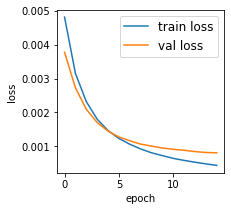

ThreeLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.005116587039083242
    Val loss: 0.004365752451121807
    Train acc: 0.42471127717391305
    Val acc: 0.6042668269230769


    Train loss: 0.003762540640309453
    Val loss: 0.0033852437045425177
    Train acc: 0.6772927989130435
    Val acc: 0.7134915865384616


    Train loss: 0.002902524545788765
    Val loss: 0.0026573447976261377
    Train acc: 0.7562839673913043
    Val acc: 0.7647235576923077


    Train loss: 0.002266435418277979
    Val loss: 0.002131491433829069
    Train acc: 0.8039402173913044
    Val acc: 0.7950721153846154


    Train loss: 0.0018025492317974567
    Val loss: 0.001758906408213079
    Train acc: 0.8386548913043478
    Val acc: 0.8156550480769231


    Train loss: 0.0014554410008713603
    Val loss: 0.0015263018431141973
    Train acc: 0.8634680706521739
    Val acc: 0.8285757211538461


    Train loss: 0.0012069855583831668
    Val loss: 0.0013438405003398657
    Train acc: 0.8818274456521739
    Val acc: 0.8381911057692307


    Train loss: 0.001019189367070794
    Val loss: 0.0012106014182791114
    Train acc: 0.8983525815217391
    Val acc: 0.8467548076923077


    Train loss: 0.0008654743432998657
    Val loss: 0.00110316788777709
    Train acc: 0.9117357336956522
    Val acc: 0.8478064903846154


    Train loss: 0.0007598566589877009
    Val loss: 0.001053718733601272
    Train acc: 0.923046875
    Val acc: 0.8523137019230769


    Train loss: 0.0006586639792658389
    Val loss: 0.0010054168524220586
    Train acc: 0.9322860054347826
    Val acc: 0.8526141826923077


    Train loss: 0.0005798619822598994
    Val loss: 0.0009510530508123338
    Train acc: 0.9393682065217391
    Val acc: 0.8569711538461539


    Train loss: 0.0005175524856895208
    Val loss: 0.0009353085188195109
    Train acc: 0.9477751358695652
    Val acc: 0.8580228365384616


    Train loss: 0.00045489915646612644
    Val loss: 0.0008940802072174847
    Train acc: 0.9534476902173913
    Val acc: 0.8590745192307693


    Train loss: 0.0004029159026686102
    Val loss: 0.0008840888040140271
    Train acc: 0.958203125
    Val acc: 0.8596754807692307


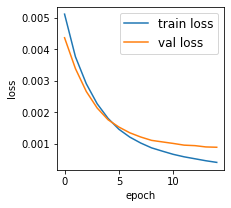

ThreeLayersFullyConnectedLettersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2352, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)


    Train loss: 0.005292072892189026
    Val loss: 0.004621478263288736
    Train acc: 0.3593240489130435
    Val acc: 0.5256911057692307


    Train loss: 0.004081709776073694
    Val loss: 0.003727942705154419
    Train acc: 0.6076766304347826
    Val acc: 0.65234375


    Train loss: 0.0032849302515387535
    Val loss: 0.002999685937538743
    Train acc: 0.7030570652173913
    Val acc: 0.71875


    Train loss: 0.0026435558684170246
    Val loss: 0.0024478835985064507
    Train acc: 0.7610903532608696
    Val acc: 0.7605168269230769


    Train loss: 0.002149678999558091
    Val loss: 0.002042138949036598
    Train acc: 0.7998301630434783
    Val acc: 0.7856069711538461


    Train loss: 0.0017690157983452082
    Val loss: 0.0017423671670258045
    Train acc: 0.8280061141304348
    Val acc: 0.8051382211538461


    Train loss: 0.00149623048491776
    Val loss: 0.00152404117397964
    Train acc: 0.8477072010869565
    Val acc: 0.8168569711538461


    Train loss: 0.001300573698244989
    Val loss: 0.0013621875550597906
    Train acc: 0.8637398097826087
    Val acc: 0.8303786057692307


    Train loss: 0.0011251025134697556
    Val loss: 0.0012469550129026175
    Train acc: 0.8763247282608696
    Val acc: 0.8351862980769231


    Train loss: 0.001005672849714756
    Val loss: 0.0011735475854948163
    Train acc: 0.8878396739130435
    Val acc: 0.8396935096153846


    Train loss: 0.0008962277206592262
    Val loss: 0.001102515496313572
    Train acc: 0.8969429347826087
    Val acc: 0.8463040865384616


    Train loss: 0.0008107688627205789
    Val loss: 0.001052370760589838
    Train acc: 0.904891304347826
    Val acc: 0.8490084134615384


    Train loss: 0.0007450769189745188
    Val loss: 0.000988896586932242
    Train acc: 0.9118376358695652
    Val acc: 0.8529146634615384


    Train loss: 0.0006780484691262245
    Val loss: 0.0009578047902323306
    Train acc: 0.9193953804347826
    Val acc: 0.8539663461538461


    Train loss: 0.0006248392746783793
    Val loss: 0.0009319828823208809
    Train acc: 0.9242866847826087
    Val acc: 0.8539663461538461


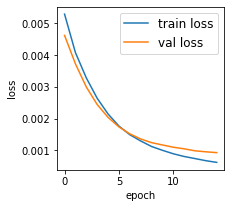

In [71]:
parametrs = [[1024, 512, 128, 64], [2048, 512, 64, 32], [512, 256, 64, 32]]
models = [ThreeLayersFullyConnectedLettersModel(28*28*3, 26, hidden_size1=hs[0], hidden_size2=hs[1], hidden_size3=hs[2], hidden_size4=hs[2]) 
          for hs in parametrs]

num_neurons_metrics = {'loss':[], 'acc':[]}
for i in range(len(models)):
    optimizer = optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9)
    print(models[i])
    metrics = train(models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=15)
    num_neurons_metrics['loss'].append(metrics['loss'])
    num_neurons_metrics['acc'].append(metrics['acc'])

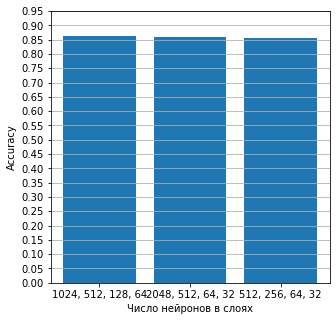

In [75]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(3), num_neurons_metrics['acc'], tick_label=['1024, 512, 128, 64', '2048, 512, 64, 32','512, 256, 64, 32'])

plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel('Число нейронов в слоях')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()

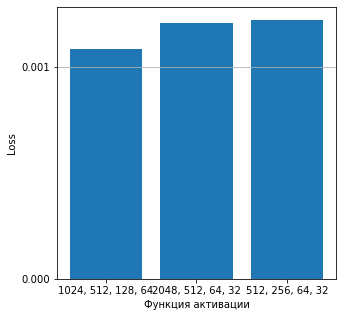

In [76]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(3), num_neurons_metrics['loss'], tick_label=['1024, 512, 128, 64', '2048, 512, 64, 32','512, 256, 64, 32'])
plt.yticks(np.arange(0, np.max(num_neurons_metrics['loss']), 0.001))

plt.xlabel('Функция активации')
plt.ylabel('Loss')

plt.grid(axis = 'y')
plt.show()

Лучшее каечство получилось у трехслойной модели с параметрами **hs1 = 1024, hs2 = 512, hs3 = 128, hs4 = 64**

#### Тренировка ThreeLayersFullyConnectedLettersModel c лучшими параметрами:
* batch size = 32
* learning rate = 0.001
* число нейронов в слоях - hs1 = 1024, hs2 = 512, hs3 = 128, hs4 = 64
* функция активации - ReLU


    Train loss: 0.00508181843906641
    Val loss: 0.004210940096527338
    Train acc: 0.43116508152173916
    Val acc: 0.6044170673076923


    Train loss: 0.00367924477905035
    Val loss: 0.0032747278455644846
    Train acc: 0.6750169836956522
    Val acc: 0.705078125


    Train loss: 0.0028674111235886812
    Val loss: 0.002608778653666377
    Train acc: 0.7494395380434783
    Val acc: 0.7560096153846154


    Train loss: 0.002289864234626293
    Val loss: 0.0020991810597479343
    Train acc: 0.7943444293478261
    Val acc: 0.7890625


    Train loss: 0.001852685702033341
    Val loss: 0.0017557317623868585
    Train acc: 0.8242866847826087
    Val acc: 0.8076923076923077


    Train loss: 0.0015342585975304246
    Val loss: 0.001514800707809627
    Train acc: 0.8466711956521739
    Val acc: 0.8239182692307693


    Train loss: 0.0013013507705181837
    Val loss: 0.001329595223069191
    Train acc: 0.8642493206521739
    Val acc: 0.8336838942307693


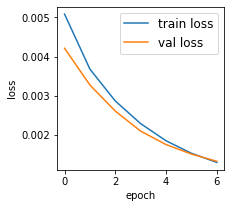

{'loss': tensor(0.0018), 'acc': tensor(0.8337)}

In [36]:
best_3l_model = ThreeLayersFullyConnectedLettersModel(28*28*3, 26)
optimizer = optim.SGD(best_3l_model.parameters(), lr=0.001, momentum=0.9)
train(best_3l_model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=7)

Сравнение качества 2х- и 3х- слойных моделей:

In [48]:
y_pred_2lm = best_2l_model(test_dataset.X.permute(0, 3, 1, 2))
pred_classes_2lm = torch.argmax(y_pred_2lm, dim=-1)
loss = criterion(y_pred_2lm, test_dataset.y) 
loss

tensor(0.3338, grad_fn=<NllLossBackward>)

In [51]:
y_pred_3lm = best_3l_model(test_dataset.X.permute(0, 3, 1, 2))
pred_classes_3lm = torch.argmax(y_pred_3lm, dim=-1)
loss = criterion(y_pred_3lm, test_dataset.y)
loss

tensor(0.2176, grad_fn=<NllLossBackward>)

В качестве ***наилучшей полносвязной модели*** будет использоваться **трехслойная модель**, тк она имеет меньший loss.

**2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.**

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [38]:
alphabet=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [41]:
y_pred = best_3l_model(test_dataset.X.permute(0, 3, 1, 2))
pred_classes = torch.argmax(y_pred, dim=-1)
conf_matrix = confusion_matrix(test_dataset.y, pred_classes)
class_acc = np.mean(100*conf_matrix.diagonal()/conf_matrix.sum(1))
print("Test accuracy:", class_acc)

Test accuracy: 88.68938728082722


Text(0.5, 69.0, 'Predicted label')

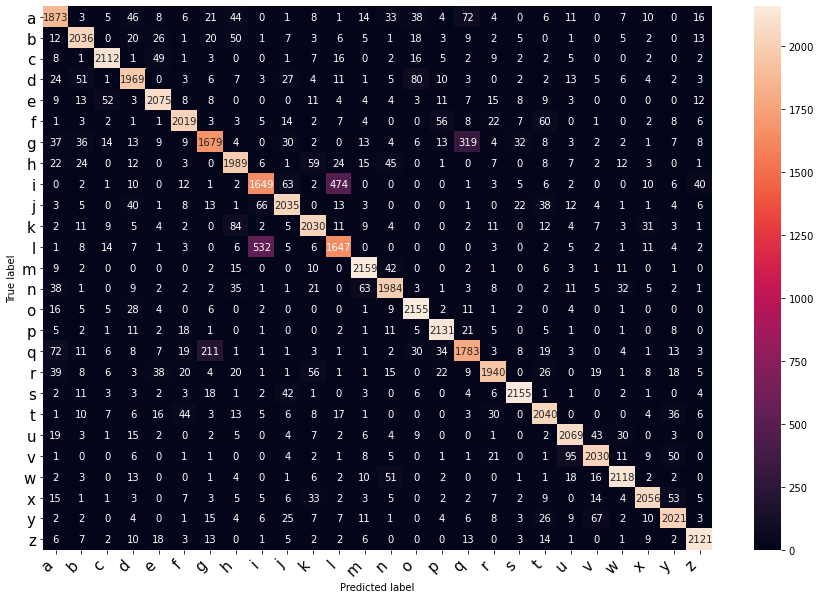

In [42]:
plt.figure(figsize=(15,10))

df_conf_matrix = pd.DataFrame(conf_matrix, index=alphabet, columns=alphabet).astype(int)
heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel("True label")
plt.xlabel("Predicted label")

**3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.**

In [43]:
sums_pairs_of_mixed_letters = {(alphabet[i], alphabet[j]): conf_matrix[i, j] + conf_matrix[j, i] for i in range(0, 26) for j in range(i + 1, 26)}
top_similar_letters = sorted(sums_pairs_of_mixed_letters.items(), key=lambda x: x[1])[len(sums_pairs_of_mixed_letters) - 10:]
top_similar_letters

[(('f', 't'), 104),
 (('m', 'n'), 105),
 (('d', 'o'), 108),
 (('v', 'y'), 117),
 (('i', 'j'), 129),
 (('u', 'v'), 138),
 (('h', 'k'), 143),
 (('a', 'q'), 144),
 (('g', 'q'), 530),
 (('i', 'l'), 1006)]

In [44]:
indexes_similar_letters = {}
for similar_letters, _ in top_similar_letters:
    one_is_two = torch.logical_and(pred_classes==alphabet.index(similar_letters[0]), test_dataset.y==alphabet.index(similar_letters[1]))
    two_is_one = torch.logical_and(pred_classes==alphabet.index(similar_letters[1]), test_dataset.y==alphabet.index(similar_letters[0]))
    indexes_similar_letters[similar_letters] = (torch.logical_or(one_is_two, two_is_one)==True).nonzero()


In [45]:
def print_same_letters(indexes_similar_letters):
    for letters, indexes in indexes_similar_letters.items():
        print('The same %s and %s:' % (letters[0], letters[1]))
        n = 10 if len(indexes) >=10 else len(indexes)
        f = plt.figure(figsize=(n, n))
        idxs = random.sample(range(0, len(indexes)), n)
        for i in range(n):
            # Debug, plot figure
            f.add_subplot(1, n, i + 1)
            plt.imshow(train_dataset.X[int(indexes[idxs[i]])].detach().numpy().astype(np.int))

        plt.show(block=True)

The same f and t:


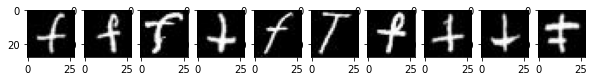

The same m and n:


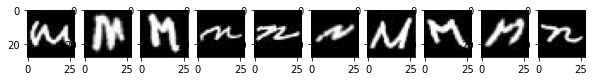

The same d and o:


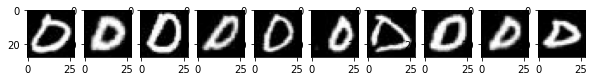

The same v and y:


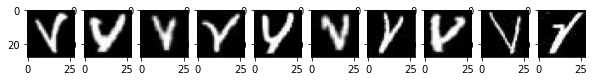

The same i and j:


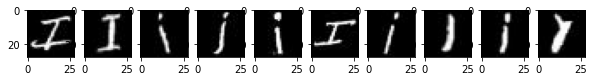

The same u and v:


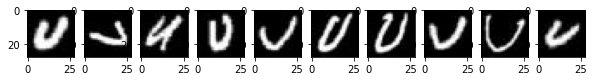

The same h and k:


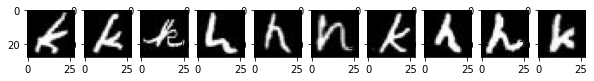

The same a and q:


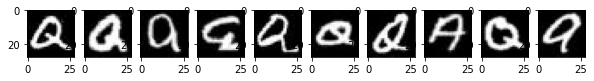

The same g and q:


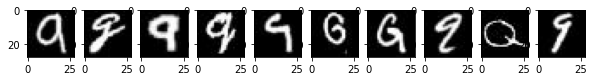

The same i and l:


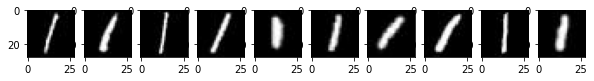

In [46]:
print_same_letters(indexes_similar_letters)

4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву? 

In [47]:
l_index = alphabet.index('l')
print('l detection accuracy:', conf_matrix[l_index, l_index] / sum(conf_matrix[l_index]))

l detection accuracy: 0.7287610619469026


In [48]:
sums_pairs_of_mixed_letters = {('l', alphabet[i]): conf_matrix[l_index, i] + conf_matrix[i, l_index] for i in range(0, 26) if i != l_index }
top_similar_letters = sorted(sums_pairs_of_mixed_letters.items(), key=lambda x: x[1])[-3:]

In [49]:
top_similar_letters

[(('l', 'c'), 30), (('l', 'h'), 30), (('l', 'i'), 1006)]

In [50]:
indexes_similar_letters = {}
for similar_letters, _ in top_similar_letters:
    one_is_two = torch.logical_and(pred_classes==alphabet.index(similar_letters[0]), test_dataset.y==alphabet.index(similar_letters[1]))
    two_is_one = torch.logical_and(pred_classes==alphabet.index(similar_letters[1]), test_dataset.y==alphabet.index(similar_letters[0]))
    indexes_similar_letters[similar_letters] = (torch.logical_or(one_is_two, two_is_one)==True).nonzero()

The same l and c:


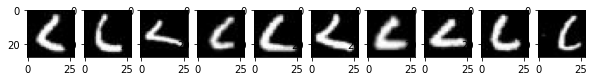

The same l and h:


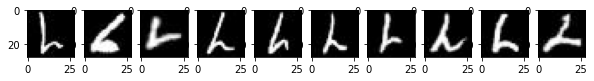

The same l and i:


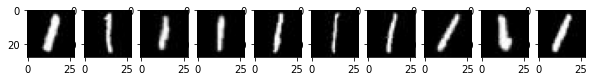

In [51]:
print_same_letters(indexes_similar_letters)

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
**1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.**   

In [12]:
class OneLayersConvLettersModel(nn.Module):
    def __init__(self, kernel_size=5, out_channels=10):
        super(OneLayersConvLettersModel, self).__init__()
        in_linear = int((((28-kernel_size+1)/2)**2)*out_channels)
        
        self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_linear, 128)
        self.linear2 = nn.Linear(128, 26)
        self.ReLU = nn.ReLU()
        
    
    def forward(self, x):
        x = self.conv(x)
        x = self.ReLU(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
    
        return x

In [13]:
class TwoLayersConvLettersModel(nn.Module):
    def __init__(self, kernel_size1=5, kernel_size2=3, out_channels1=20, out_channels2=40):
        super(TwoLayersConvLettersModel, self).__init__()
        
        in_linear = int((((((28-kernel_size1+1)/2)-kernel_size2+1)/2)**2)*out_channels2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels1, kernel_size=kernel_size1)
        self.conv2 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel_size2)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_linear, 512)
        self.linear2 = nn.Linear(512, 26)
        self.ReLU = nn.ReLU()
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
    
        return x

In [33]:
class ThreeLayersConvLettersModel(nn.Module):
    def __init__(self, kernel_size1=3, kernel_size2=3, kernel_size3=3, out_channels1=20, out_channels2=40, out_channels3=60):
        super(ThreeLayersConvLettersModel, self).__init__()
        
        in_linear = int((((((28-kernel_size1+1)/2)-kernel_size2+1)-kernel_size3+1)**2)*out_channels3)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels1, kernel_size=kernel_size1)
        self.conv2 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=kernel_size2)
        self.conv3 = nn.Conv2d(in_channels=out_channels2, out_channels=out_channels3, kernel_size=kernel_size3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_linear, 512)
        self.linear2 = nn.Linear(512, 26)
        self.bn1 = nn.BatchNorm1d(512)
        self.ReLU = nn.ReLU()
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
    
        return x

По примеру полносвязных моделей **batch_size = 32**.

Обучение модели с одним сверточным слоем с использованием различных параметров:

In [14]:
# filter sizes 
kernel_sizes = [3, 5]
# filter numbers
out_channels = [10, 20, 50, 100]
# create models with different parametrs of filter sizes and filter numbers
models = [OneLayersConvLettersModel(kernel_size=k_s, out_channels=o_ch) for k_s in kernel_sizes for o_ch in out_channels]
criterion = nn.CrossEntropyLoss()


OneLayersConvLettersModel(
  (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1690, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


C:\Users\Polina\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


    Train loss: 0.02705918438732624
    Val loss: 0.019177690148353577
    Train acc: 0.743114406779661
    Val acc: 0.8204656862745098


    Train loss: 0.014086886309087276
    Val loss: 0.017541831359267235
    Train acc: 0.8552829414980864
    Val acc: 0.8475796568627451


    Train loss: 0.011488683521747589
    Val loss: 0.016165170818567276
    Train acc: 0.8787930563149262
    Val acc: 0.8549325980392157


    Train loss: 0.00991247408092022
    Val loss: 0.014601591974496841
    Train acc: 0.893965281574631
    Val acc: 0.8587622549019608


    Train loss: 0.009067044593393803
    Val loss: 0.017843013629317284
    Train acc: 0.9038750683433571
    Val acc: 0.8382352941176471


    Train loss: 0.007915721274912357
    Val loss: 0.01970023475587368
    Train acc: 0.9128280481137233
    Val acc: 0.8673406862745098


    Train loss: 0.007182362489402294
    Val loss: 0.018032217398285866
    Train acc: 0.9198332422088573
    Val acc: 0.8498774509803921


    Train loss: 0.006659115664660931
    Val loss: 0.017507992684841156
    Train acc: 0.9253861399671952
    Val acc: 0.8645833333333334


    Train loss: 0.005963163450360298
    Val loss: 0.01801149547100067
    Train acc: 0.9298284581738655
    Val acc: 0.8520220588235294


    Train loss: 0.005761386826634407
    Val loss: 0.018235381692647934
    Train acc: 0.9330405959540733
    Val acc: 0.8481924019607843


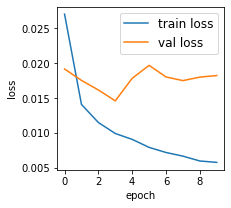

OneLayersConvLettersModel(
  (conv): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3380, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.02664043940603733
    Val loss: 0.01788133941590786
    Train acc: 0.7771152268999453
    Val acc: 0.8264399509803921


    Train loss: 0.012906554155051708
    Val loss: 0.015806755051016808
    Train acc: 0.8680973209404046
    Val acc: 0.8475796568627451


    Train loss: 0.01061081513762474
    Val loss: 0.01462727040052414
    Train acc: 0.8891641607435757
    Val acc: 0.8581495098039216


    Train loss: 0.009062433615326881
    Val loss: 0.013996546156704426
    Train acc: 0.9015513942044833
    Val acc: 0.8616727941176471


    Train loss: 0.008229655213654041
    Val loss: 0.017022674903273582
    Train acc: 0.9096671678512849
    Val acc: 0.8518688725490197


    Train loss: 0.0073274909518659115
    Val loss: 0.015775734558701515
    Train acc: 0.9181588299617277
    Val acc: 0.8558517156862745


    Train loss: 0.006898199208080769
    Val loss: 0.015447135083377361
    Train acc: 0.9237458993985784
    Val acc: 0.8659620098039216


    Train loss: 0.006703107617795467
    Val loss: 0.016892071813344955
    Train acc: 0.9239851011481685
    Val acc: 0.8635110294117647


    Train loss: 0.005759203806519508
    Val loss: 0.017372744157910347
    Train acc: 0.9328184800437398
    Val acc: 0.8569240196078431


    Train loss: 0.005690979305654764
    Val loss: 0.01983007974922657
    Train acc: 0.9343391197375616
    Val acc: 0.8530943627450981


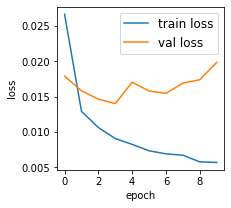

OneLayersConvLettersModel(
  (conv): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=8450, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.0297713540494442
    Val loss: 0.015393467620015144
    Train acc: 0.7939447785675232
    Val acc: 0.8420649509803921


    Train loss: 0.011170350946485996
    Val loss: 0.013608496636152267
    Train acc: 0.8840554948059048
    Val acc: 0.8648897058823529


    Train loss: 0.008622813038527966
    Val loss: 0.01283679623156786
    Train acc: 0.906130399125205
    Val acc: 0.8708639705882353


    Train loss: 0.007166086696088314
    Val loss: 0.014050161466002464
    Train acc: 0.9189276927282668
    Val acc: 0.8708639705882353


    Train loss: 0.006118588615208864
    Val loss: 0.015413417480885983
    Train acc: 0.931656642974303
    Val acc: 0.8667279411764706


    Train loss: 0.0053842561319470406
    Val loss: 0.01742304116487503
    Train acc: 0.9370386823400766
    Val acc: 0.8651960784313726


    Train loss: 0.005079898051917553
    Val loss: 0.01713266596198082
    Train acc: 0.940643794423182
    Val acc: 0.8699448529411765


    Train loss: 0.004134930204600096
    Val loss: 0.018922489136457443
    Train acc: 0.9499726626571897
    Val acc: 0.8576899509803921


    Train loss: 0.0039820242673158646
    Val loss: 0.0195159874856472
    Train acc: 0.9537657189721159
    Val acc: 0.8700980392156863


    Train loss: 0.004049560520797968
    Val loss: 0.022890586405992508
    Train acc: 0.9514933023510115
    Val acc: 0.8687193627450981


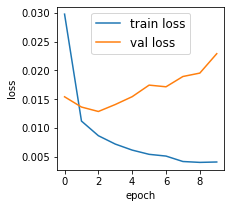

OneLayersConvLettersModel(
  (conv): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=16900, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.059721965342760086
    Val loss: 0.016673045232892036
    Train acc: 0.7842571077091307
    Val acc: 0.8376225490196079


    Train loss: 0.011871482245624065
    Val loss: 0.013937733136117458
    Train acc: 0.878177966101695
    Val acc: 0.8612132352941176


    Train loss: 0.00941290520131588
    Val loss: 0.015060611069202423
    Train acc: 0.8995694368507381
    Val acc: 0.8613664215686274


    Train loss: 0.00795204658061266
    Val loss: 0.014436768367886543
    Train acc: 0.9123667304537999
    Val acc: 0.8651960784313726


    Train loss: 0.006620905362069607
    Val loss: 0.015944231301546097
    Train acc: 0.925215281574631
    Val acc: 0.8667279411764706


    Train loss: 0.005761663429439068
    Val loss: 0.016497526317834854
    Train acc: 0.9333823127392018
    Val acc: 0.8613664215686274


    Train loss: 0.005477809812873602
    Val loss: 0.022353438660502434
    Train acc: 0.9364577638053582
    Val acc: 0.8648897058823529


    Train loss: 0.004746303427964449
    Val loss: 0.01971212401986122
    Train acc: 0.9454790869327502
    Val acc: 0.8581495098039216


    Train loss: 0.004899635445326567
    Val loss: 0.02113853394985199
    Train acc: 0.9445735374521597
    Val acc: 0.8651960784313726


    Train loss: 0.004260816145688295
    Val loss: 0.021436557173728943
    Train acc: 0.9487083105522143
    Val acc: 0.8647365196078431


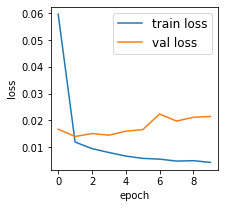

OneLayersConvLettersModel(
  (conv): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1440, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.02880759723484516
    Val loss: 0.019086293876171112
    Train acc: 0.7280617823947513
    Val acc: 0.8170955882352942


    Train loss: 0.01563742570579052
    Val loss: 0.018306275829672813
    Train acc: 0.8415288408966648
    Val acc: 0.8178615196078431


    Train loss: 0.01343182846903801
    Val loss: 0.015536000020802021
    Train acc: 0.8631253417167851
    Val acc: 0.8365502450980392


    Train loss: 0.011649812571704388
    Val loss: 0.017335835844278336
    Train acc: 0.8806212411153636
    Val acc: 0.8348651960784313


    Train loss: 0.010821724310517311
    Val loss: 0.017009856179356575
    Train acc: 0.8864987698195735
    Val acc: 0.8529411764705882


    Train loss: 0.010112778283655643
    Val loss: 0.01640545204281807
    Train acc: 0.895178376161837
    Val acc: 0.8604473039215687


    Train loss: 0.009283371269702911
    Val loss: 0.01958809606730938
    Train acc: 0.9010900765445599
    Val acc: 0.8494178921568627


    Train loss: 0.008836926892399788
    Val loss: 0.018057798966765404
    Train acc: 0.904678102788409
    Val acc: 0.8412990196078431


    Train loss: 0.008129492402076721
    Val loss: 0.019038742408156395
    Train acc: 0.9110682066703116
    Val acc: 0.8247549019607843


    Train loss: 0.007349690422415733
    Val loss: 0.017357435077428818
    Train acc: 0.9180563149261892
    Val acc: 0.8607536764705882


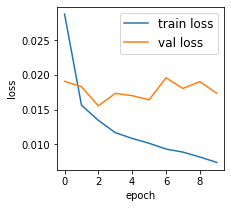

OneLayersConvLettersModel(
  (conv): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2880, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.028466321527957916
    Val loss: 0.018061356619000435
    Train acc: 0.7355282941498087
    Val acc: 0.8187806372549019


    Train loss: 0.013793080113828182
    Val loss: 0.01580680161714554
    Train acc: 0.8601694915254238
    Val acc: 0.8471200980392157


    Train loss: 0.011800664477050304
    Val loss: 0.018316302448511124
    Train acc: 0.8782121377802078
    Val acc: 0.8428308823529411


    Train loss: 0.010087705217301846
    Val loss: 0.014951503835618496
    Train acc: 0.8928376161837069
    Val acc: 0.8552389705882353


    Train loss: 0.009485810995101929
    Val loss: 0.017586417496204376
    Train acc: 0.8996036085292509
    Val acc: 0.852328431372549


    Train loss: 0.008440110832452774
    Val loss: 0.01480881031602621
    Train acc: 0.9082148715144888
    Val acc: 0.8627450980392157


    Train loss: 0.00766882486641407
    Val loss: 0.01591520942747593
    Train acc: 0.9152029797703664
    Val acc: 0.8705575980392157


    Train loss: 0.007178578060120344
    Val loss: 0.01987530291080475
    Train acc: 0.9198674138873701
    Val acc: 0.8673406862745098


    Train loss: 0.0067554498091340065
    Val loss: 0.016505220904946327
    Train acc: 0.9241559595407326
    Val acc: 0.8638174019607843


    Train loss: 0.006442676298320293
    Val loss: 0.01844332553446293
    Train acc: 0.9277439857845817
    Val acc: 0.8713235294117647


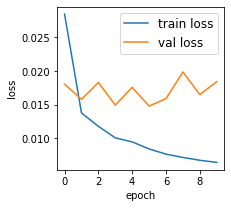

OneLayersConvLettersModel(
  (conv): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=7200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.026528004556894302
    Val loss: 0.01586698368191719
    Train acc: 0.7723141060688901
    Val acc: 0.8374693627450981


    Train loss: 0.011820892803370953
    Val loss: 0.013649440370500088
    Train acc: 0.8784000820120285
    Val acc: 0.8648897058823529


    Train loss: 0.009447814896702766
    Val loss: 0.017028337344527245
    Train acc: 0.898356342263532
    Val acc: 0.866421568627451


    Train loss: 0.008214235305786133
    Val loss: 0.015964217483997345
    Train acc: 0.9094963094587206
    Val acc: 0.8624387254901961


    Train loss: 0.007093037478625774
    Val loss: 0.016015952453017235
    Train acc: 0.920465418261345
    Val acc: 0.8759191176470589


    Train loss: 0.006346283946186304
    Val loss: 0.016160624101758003
    Train acc: 0.9286837069436851
    Val acc: 0.8768382352941176


    Train loss: 0.005999364424496889
    Val loss: 0.01564851962029934
    Train acc: 0.9317249863313286
    Val acc: 0.8783700980392157


    Train loss: 0.005284522660076618
    Val loss: 0.01930362544953823
    Train acc: 0.9382859486057955
    Val acc: 0.8681066176470589


    Train loss: 0.005224118009209633
    Val loss: 0.028271574527025223
    Train acc: 0.9397040732640787
    Val acc: 0.8563112745098039


    Train loss: 0.005275926552712917
    Val loss: 0.020739473402500153
    Train acc: 0.940882996172772
    Val acc: 0.8687193627450981


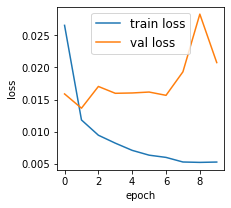

OneLayersConvLettersModel(
  (conv): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=14400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.03404468670487404
    Val loss: 0.018957845866680145
    Train acc: 0.7979770366320393
    Val acc: 0.8382352941176471


    Train loss: 0.011482985690236092
    Val loss: 0.01636047288775444
    Train acc: 0.8815438764352105
    Val acc: 0.8503370098039216


    Train loss: 0.00922502763569355
    Val loss: 0.013764829374849796
    Train acc: 0.9022006560962275
    Val acc: 0.8622855392156863


    Train loss: 0.0077393245883286
    Val loss: 0.015470601618289948
    Train acc: 0.9149125205030071
    Val acc: 0.8584558823529411


    Train loss: 0.006938142701983452
    Val loss: 0.013109426014125347
    Train acc: 0.9222936030617824
    Val acc: 0.8777573529411765


    Train loss: 0.0061937784776091576
    Val loss: 0.016257094219326973
    Train acc: 0.9293500546746856
    Val acc: 0.8707107843137255


    Train loss: 0.005678164307028055
    Val loss: 0.014840415678918362
    Train acc: 0.9352617550574084
    Val acc: 0.8766850490196079


    Train loss: 0.005285377614200115
    Val loss: 0.017201924696564674
    Train acc: 0.9388839529797703
    Val acc: 0.8707107843137255


    Train loss: 0.004950052127242088
    Val loss: 0.01861477456986904
    Train acc: 0.9422840349917988
    Val acc: 0.866421568627451


    Train loss: 0.00516848498955369
    Val loss: 0.019255628809332848
    Train acc: 0.9422327774740296
    Val acc: 0.8682598039215687


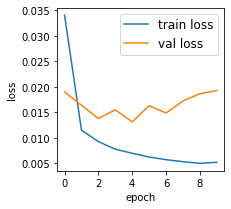

In [15]:
one_layer_metrics = {'loss': [], 'acc': []}
for i in range(len(models)):
    print(models[i])
    optimizer = optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9)
    metrics = train(models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10)
    one_layer_metrics['loss'].append(metrics['loss'])
    one_layer_metrics['acc'].append(metrics['acc'])

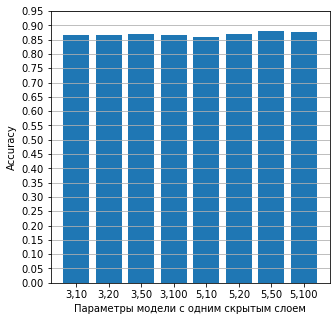

In [106]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(8), one_layer_metrics['acc'], tick_label=['3,10', '3,20', '3,50', '3,100','5,10', '5,20', '5,50', '5,100'])

plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel('Параметры модели с одним скрытым слоем')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()

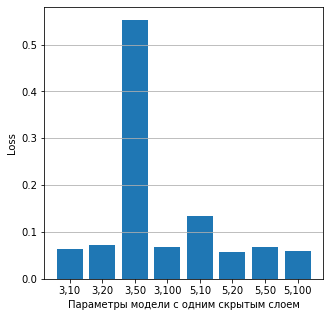

In [111]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(8), one_layer_metrics['loss'], tick_label=['3,10', '3,20', '3,50', '3,100','5,10', '5,20', '5,50', '5,100'])

plt.yticks(np.arange(0, np.max(one_layer_metrics['loss']), 0.1))

plt.xlabel('Параметры модели с одним скрытым слоем')
plt.ylabel('Loss')

plt.grid(axis = 'y')
plt.show()

Лучшие характеристики имеет **one_layer_model** c параметрами **kernel_size=5, out_channels=50**.

Выбор модели с двумя сверточными слоями:

In [179]:
models = [TwoLayersConvLettersModel(kernel_size1=5, kernel_size2=3, out_channels1=10, out_channels2=20),
          TwoLayersConvLettersModel(kernel_size1=5, kernel_size2=3, out_channels1=10, out_channels2=30),
          TwoLayersConvLettersModel(kernel_size1=5, kernel_size2=5, out_channels1=30, out_channels2=50),
          TwoLayersConvLettersModel(kernel_size1=5, kernel_size2=5, out_channels1=20, out_channels2=60)]

TwoLayersConvLettersModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=500, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.021407600492239
    Val loss: 0.013822433538734913
    Train acc: 0.7939618644067796
    Val acc: 0.8602941176470589


    Train loss: 0.010518289171159267
    Val loss: 0.010509028099477291
    Train acc: 0.8905822854018589
    Val acc: 0.890625


    Train loss: 0.008556166663765907
    Val loss: 0.009951956570148468
    Train acc: 0.9084540732640787
    Val acc: 0.8921568627450981


    Train loss: 0.007297443225979805
    Val loss: 0.009926910512149334
    Train acc: 0.9196965554948059
    Val acc: 0.8920036764705882


    Train loss: 0.006413404364138842
    Val loss: 0.011041553691029549
    Train acc: 0.9280686167304538
    Val acc: 0.8880208333333334


    Train loss: 0.005776845850050449
    Val loss: 0.010524971410632133
    Train acc: 0.9325109349371241
    Val acc: 0.8941482843137255


    Train loss: 0.005115762818604708
    Val loss: 0.01055322214961052
    Train acc: 0.9409000820120285
    Val acc: 0.8979779411764706


    Train loss: 0.004699205048382282
    Val loss: 0.01001615822315216
    Train acc: 0.944265992345544
    Val acc: 0.9042585784313726


    Train loss: 0.004439292009919882
    Val loss: 0.010958961211144924
    Train acc: 0.9463333788955713
    Val acc: 0.8995098039215687


    Train loss: 0.004039995837956667
    Val loss: 0.01150808110833168
    Train acc: 0.9504681519956261
    Val acc: 0.8956801470588235


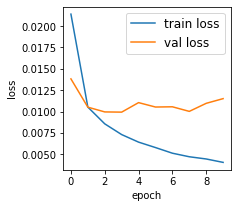

TwoLayersConvLettersModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=750, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.027059929445385933
    Val loss: 0.015438232570886612
    Train acc: 0.7417817113176599
    Val acc: 0.8567708333333334


    Train loss: 0.010632439516484737
    Val loss: 0.011020926758646965
    Train acc: 0.8894887916894478
    Val acc: 0.8875612745098039


    Train loss: 0.008177858777344227
    Val loss: 0.009874887764453888
    Train acc: 0.9113928376161837
    Val acc: 0.9001225490196079


    Train loss: 0.00669879512861371
    Val loss: 0.010738722048699856
    Train acc: 0.9258303717878622
    Val acc: 0.8964460784313726


    Train loss: 0.005777763668447733
    Val loss: 0.010298310779035091
    Train acc: 0.9331601968288682
    Val acc: 0.8993566176470589


    Train loss: 0.004970065783709288
    Val loss: 0.010338316671550274
    Train acc: 0.9411734554401312
    Val acc: 0.8901654411764706


    Train loss: 0.004319329746067524
    Val loss: 0.011851759627461433
    Train acc: 0.948571623838163
    Val acc: 0.8993566176470589


    Train loss: 0.004191763233393431
    Val loss: 0.011721852235496044
    Train acc: 0.9524671951886277
    Val acc: 0.8955269607843137


    Train loss: 0.003696792060509324
    Val loss: 0.01210738904774189
    Train acc: 0.9547396118097321
    Val acc: 0.8985906862745098


    Train loss: 0.003418597159907222
    Val loss: 0.013484502211213112
    Train acc: 0.9568240841990159
    Val acc: 0.8944546568627451


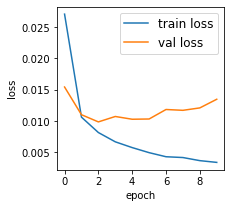

TwoLayersConvLettersModel(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 50, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.0350041538476944
    Val loss: 0.012786525301635265
    Train acc: 0.6678171131765992
    Val acc: 0.8681066176470589


    Train loss: 0.01167101226747036
    Val loss: 0.011967265978455544
    Train acc: 0.8803307818480044
    Val acc: 0.8834252450980392


    Train loss: 0.009094246663153172
    Val loss: 0.01091008074581623
    Train acc: 0.9026790595954073
    Val acc: 0.899203431372549


    Train loss: 0.007658813148736954
    Val loss: 0.01072539109736681
    Train acc: 0.9159889283761619
    Val acc: 0.8918504901960784


    Train loss: 0.006750837899744511
    Val loss: 0.009781873784959316
    Train acc: 0.92316498086386
    Val acc: 0.8970588235294118


    Train loss: 0.005930239334702492
    Val loss: 0.010173503309488297
    Train acc: 0.930734007654456
    Val acc: 0.9027267156862745


    Train loss: 0.005374410655349493
    Val loss: 0.009819244965910912
    Train acc: 0.9374145708037179
    Val acc: 0.9001225490196079


    Train loss: 0.0048457179218530655
    Val loss: 0.009540931321680546
    Train acc: 0.941446828868234
    Val acc: 0.9041053921568627


    Train loss: 0.004499359987676144
    Val loss: 0.009467133320868015
    Train acc: 0.9453765718972116
    Val acc: 0.9091605392156863


    Train loss: 0.004145486745983362
    Val loss: 0.011285248212516308
    Train acc: 0.949135456533625
    Val acc: 0.9011948529411765


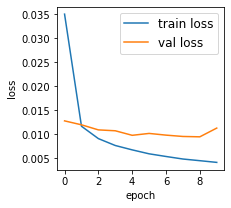

TwoLayersConvLettersModel(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 60, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=960, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (ReLU): ReLU()
)


    Train loss: 0.02067513018846512
    Val loss: 0.013216434977948666
    Train acc: 0.8033249043193001
    Val acc: 0.8615196078431373


    Train loss: 0.00936354324221611
    Val loss: 0.010057785548269749
    Train acc: 0.9009704756697648
    Val acc: 0.9013480392156863


    Train loss: 0.007337645627558231
    Val loss: 0.008497036062180996
    Train acc: 0.9187568343357025
    Val acc: 0.9036458333333334


    Train loss: 0.006113985553383827
    Val loss: 0.008857565931975842
    Train acc: 0.9311440677966102
    Val acc: 0.9065563725490197


    Train loss: 0.005297721363604069
    Val loss: 0.009731999598443508
    Train acc: 0.9385422361946418
    Val acc: 0.907015931372549


    Train loss: 0.004725975915789604
    Val loss: 0.008378841914236546
    Train acc: 0.9441463914707491
    Val acc: 0.9105392156862745


    Train loss: 0.00428423099219799
    Val loss: 0.010930719785392284
    Train acc: 0.948657053034445
    Val acc: 0.9015012254901961


    Train loss: 0.003654324449598789
    Val loss: 0.010463465936481953
    Train acc: 0.9547566976489885
    Val acc: 0.9031862745098039


    Train loss: 0.0035227478947490454
    Val loss: 0.0107200862839818
    Train acc: 0.9570632859486058
    Val acc: 0.9083946078431373


    Train loss: 0.0033444699365645647
    Val loss: 0.010431797243654728
    Train acc: 0.9581909513395298
    Val acc: 0.9146752450980392


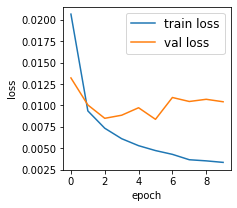

In [180]:
two_layer_metrics = {'loss': [], 'acc': []}
for i in range(len(models)):
    print(models[i])
    optimizer = optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9)
    metrics = train(models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=10)
    two_layer_metrics['loss'].append(metrics['loss'])
    two_layer_metrics['acc'].append(metrics['acc'])

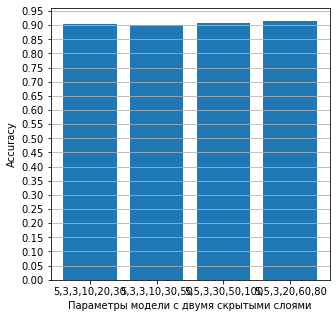

In [181]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(4), two_layer_metrics['acc'], tick_label=['5,3,3,10,20,30', '5,3,3,10,30,50', '5,5,3,30,50,100', '5,5,3,20,60,80'])

plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel('Параметры модели с двумя скрытыми слоями')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()

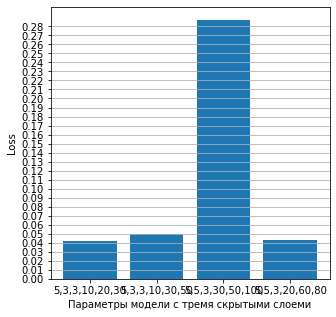

In [183]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(4), two_layer_metrics['loss'], tick_label=['5,3,3,10,20,30', '5,3,3,10,30,50', '5,5,3,30,50,100', '5,5,3,20,60,80'])

plt.yticks(np.arange(0, np.max(two_layer_metrics['loss']), 0.01))

plt.xlabel('Параметры модели с тремя скрытыми слоеми')
plt.ylabel('Loss')

plt.grid(axis = 'y')
plt.show()

In [ ]:
Лучший результат среди моделей с двумя сверточными слоями имеет моедль с параметрами: 5,5,3,20,60,80.

Обучение модели с тремя сверточными слоями с использованием различных параметров:

In [184]:
models = [ThreeLayersConvLettersModel(kernel_size1=5, kernel_size2=3, kernel_size3=3, out_channels1=10, out_channels2=20, out_channels3=30),
          ThreeLayersConvLettersModel(kernel_size1=5, kernel_size2=3, kernel_size3=3, out_channels1=10, out_channels2=30, out_channels3=50),
          ThreeLayersConvLettersModel(kernel_size1=5, kernel_size2=5, kernel_size3=3, out_channels1=30, out_channels2=50, out_channels3=100),
          ThreeLayersConvLettersModel(kernel_size1=5, kernel_size2=5, kernel_size3=3, out_channels1=20, out_channels2=60, out_channels3=120)]

ThreeLayersConvLettersModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1920, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU): ReLU()
)


    Train loss: 0.022484663873910904
    Val loss: 0.01347950380295515
    Train acc: 0.8022143247676325
    Val acc: 0.8575367647058824


    Train loss: 0.010363143868744373
    Val loss: 0.010062682442367077
    Train acc: 0.8996377802077639
    Val acc: 0.9002757352941176


    Train loss: 0.008258859626948833
    Val loss: 0.007975520566105843
    Train acc: 0.9172361946418808
    Val acc: 0.9145220588235294


    Train loss: 0.007096864283084869
    Val loss: 0.007708226330578327
    Train acc: 0.9270434663750683
    Val acc: 0.9180453431372549


    Train loss: 0.006466935854405165
    Val loss: 0.006861669942736626
    Train acc: 0.9322375615090214
    Val acc: 0.9258578431372549


    Train loss: 0.005857441574335098
    Val loss: 0.007559235207736492
    Train acc: 0.9391231547293603
    Val acc: 0.9206495098039216


    Train loss: 0.005362135823816061
    Val loss: 0.006651952397078276
    Train acc: 0.9427624384909786
    Val acc: 0.9264705882352942


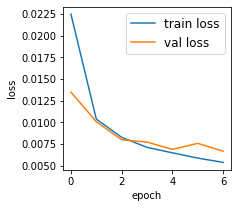

ThreeLayersConvLettersModel(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3200, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU): ReLU()
)


    Train loss: 0.020713485777378082
    Val loss: 0.010898548178374767
    Train acc: 0.8198810825587752
    Val acc: 0.8930759803921569


    Train loss: 0.009531000629067421
    Val loss: 0.008465074934065342
    Train acc: 0.9068650902132313
    Val acc: 0.9093137254901961


    Train loss: 0.007448275573551655
    Val loss: 0.007428159937262535
    Train acc: 0.9243780754510662
    Val acc: 0.9163602941176471


    Train loss: 0.006554588675498962
    Val loss: 0.006981849204748869
    Train acc: 0.9339290595954073
    Val acc: 0.9258578431372549


    Train loss: 0.005637918133288622
    Val loss: 0.006630969233810902
    Train acc: 0.9402337342810279
    Val acc: 0.9249387254901961


    Train loss: 0.004979468882083893
    Val loss: 0.006467556115239859
    Train acc: 0.9464529797703664
    Val acc: 0.9258578431372549


    Train loss: 0.004553604871034622
    Val loss: 0.007212251890450716
    Train acc: 0.9509465554948059
    Val acc: 0.9255514705882353


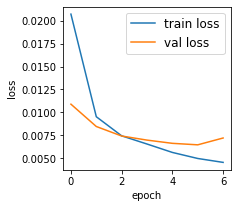

ThreeLayersConvLettersModel(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3600, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU): ReLU()
)


    Train loss: 0.01840454339981079
    Val loss: 0.009909887798130512
    Train acc: 0.8382483597594313
    Val acc: 0.9015012254901961


    Train loss: 0.008345128037035465
    Val loss: 0.007940435782074928
    Train acc: 0.9162281301257518
    Val acc: 0.9139093137254902


    Train loss: 0.006697602104395628
    Val loss: 0.006736445240676403
    Train acc: 0.930614406779661
    Val acc: 0.9257046568627451


    Train loss: 0.0058309538289904594
    Val loss: 0.006314760539680719
    Train acc: 0.9384226353198469
    Val acc: 0.9310661764705882


    Train loss: 0.005143753252923489
    Val loss: 0.005996772553771734
    Train acc: 0.9450006834335702
    Val acc: 0.9321384803921569


    Train loss: 0.004501695279031992
    Val loss: 0.006327948532998562
    Train acc: 0.9501093493712411
    Val acc: 0.9276960784313726


    Train loss: 0.004028618335723877
    Val loss: 0.00610010139644146
    Train acc: 0.9554401312192455
    Val acc: 0.9292279411764706


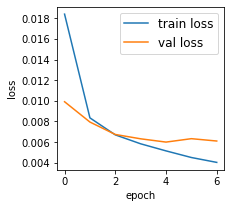

ThreeLayersConvLettersModel(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=4320, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=26, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU): ReLU()
)


    Train loss: 0.018550653010606766
    Val loss: 0.010074939578771591
    Train acc: 0.8384704756697648
    Val acc: 0.891390931372549


    Train loss: 0.008290274068713188
    Val loss: 0.007671018596738577
    Train acc: 0.91776585565883
    Val acc: 0.9171262254901961


    Train loss: 0.006584655027836561
    Val loss: 0.007072652690112591
    Train acc: 0.9305631492618918
    Val acc: 0.9188112745098039


    Train loss: 0.005684433039277792
    Val loss: 0.006572335492819548
    Train acc: 0.9402849917987972
    Val acc: 0.9231004901960784


    Train loss: 0.004889443051069975
    Val loss: 0.006581875029951334
    Train acc: 0.946999726626572
    Val acc: 0.9255514705882353


    Train loss: 0.004427181091159582
    Val loss: 0.007255168631672859
    Train acc: 0.9530139420448333
    Val acc: 0.9290747549019608


    Train loss: 0.0038646929897367954
    Val loss: 0.005968197714537382
    Train acc: 0.9576271186440678
    Val acc: 0.9316789215686274


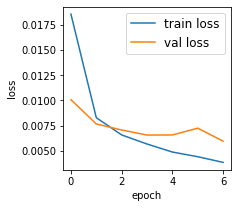

In [185]:
three_layer_metrics = {'loss': [], 'acc': []}
for i in range(len(models)):
    print(models[i])
    optimizer = optim.SGD(models[i].parameters(), lr=0.001, momentum=0.9)
    metrics = train(models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=7
                    )
    three_layer_metrics['loss'].append(metrics['loss'])
    three_layer_metrics['acc'].append(metrics['acc'])

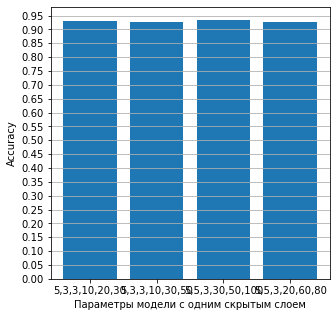

In [177]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(4), three_layer_metrics['acc'], tick_label=['5,3,3,10,20,30', '5,3,3,10,30,50', '5,5,3,30,50,100', '5,5,3,20,60,120'])

plt.yticks(np.arange(0, 1, 0.05))

plt.xlabel('Параметры модели с одним скрытым слоем')
plt.ylabel('Accuracy')

plt.grid(axis = 'y')
plt.show()

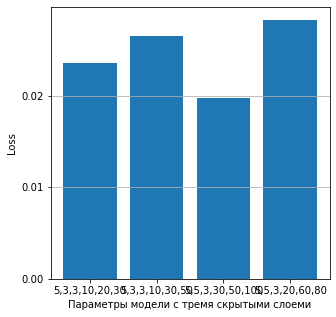

In [178]:
fig = plt.subplots(figsize =(5, 5))
plt.bar(np.arange(4), three_layer_metrics['loss'], tick_label=['5,3,3,10,20,30', '5,3,3,10,30,50', '5,5,3,30,50,100', '5,5,3,20,60,120'])

plt.yticks(np.arange(0, np.max(three_layer_metrics['loss']), 0.01))

plt.xlabel('Параметры модели с тремя скрытыми слоеми')
plt.ylabel('Loss')

plt.grid(axis = 'y')
plt.show()

Лучший результат показала модель с тремя скрыми слоями при параметах '5,5,3,30,50,100', на основе нее будет сделано следующее задание.

**2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.**

32


    Train loss: 0.018443068489432335
    Val loss: 0.010585748590528965
    Train acc: 0.8392222525970475
    Val acc: 0.9034926470588235


    Train loss: 0.008363504894077778
    Val loss: 0.0074803209863603115
    Train acc: 0.9168944778567524
    Val acc: 0.9134497549019608


    Train loss: 0.006759080570191145
    Val loss: 0.006411809474229813
    Train acc: 0.9297601148168398
    Val acc: 0.9258578431372549


    Train loss: 0.005863049533218145
    Val loss: 0.0062463413923978806
    Train acc: 0.9388156096227447
    Val acc: 0.9290747549019608


    Train loss: 0.005278840195387602
    Val loss: 0.0058318451046943665
    Train acc: 0.9444710224166211
    Val acc: 0.9313725490196079


    Train loss: 0.00478505389764905
    Val loss: 0.005680252332240343
    Train acc: 0.9489304264625479
    Val acc: 0.9260110294117647


    Train loss: 0.004213842563331127
    Val loss: 0.005551490932703018
    Train acc: 0.9534581738655002
    Val acc: 0.9307598039215687


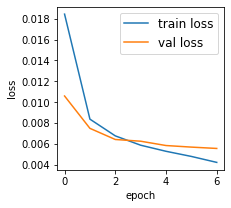

128


    Train loss: 0.0009430607315152884
    Val loss: 0.0012627089163288474
    Train acc: 0.9660378002183406
    Val acc: 0.9401041666666666


    Train loss: 0.0007517788326367736
    Val loss: 0.0012713649775832891
    Train acc: 0.968732942139738
    Val acc: 0.9391850490196079


    Train loss: 0.0008417780627496541
    Val loss: 0.0012580445036292076
    Train acc: 0.970814001091703
    Val acc: 0.9388786764705882


    Train loss: 0.000949674635194242
    Val loss: 0.0012679657666012645
    Train acc: 0.9716327783842795
    Val acc: 0.9391850490196079


    Train loss: 0.0007234992808662355
    Val loss: 0.0012706560082733631
    Train acc: 0.9727244814410481
    Val acc: 0.9378063725490197


    Train loss: 0.0007382052717730403
    Val loss: 0.0012588821118697524
    Train acc: 0.9735432587336245
    Val acc: 0.9391850490196079


    Train loss: 0.0010779035510495305
    Val loss: 0.0012960839085280895
    Train acc: 0.9743449781659389
    Val acc: 0.9373468137254902


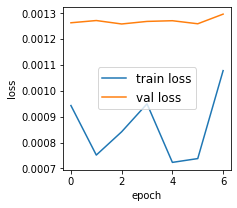

512


    Train loss: 0.00012306906864978373
    Val loss: 0.00032607995672151446
    Train acc: 0.9731997282608695
    Val acc: 0.9208233173076923


    Train loss: 0.0001202096973429434
    Val loss: 0.0003203122178092599
    Train acc: 0.9742697010869565
    Val acc: 0.9214242788461539


    Train loss: 0.00011933733185287565
    Val loss: 0.0003184070810675621
    Train acc: 0.9739979619565218
    Val acc: 0.9209735576923077


    Train loss: 0.00011825505498563871
    Val loss: 0.0003244937979616225
    Train acc: 0.9745754076086957
    Val acc: 0.9206730769230769


    Train loss: 0.00011645040649455041
    Val loss: 0.00032150279730558395
    Train acc: 0.9753226902173913
    Val acc: 0.9209735576923077


    Train loss: 0.00011628313950495794
    Val loss: 0.00031851656967774034
    Train acc: 0.9748641304347826
    Val acc: 0.9206730769230769


    Train loss: 0.00011457641812739894
    Val loss: 0.0003214380412828177
    Train acc: 0.9756114130434783
    Val acc: 0.9209735576923077


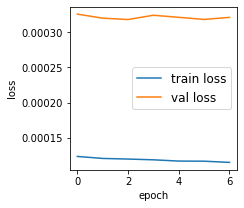

In [26]:
batch_sizes = [32, 128, 512]
bn_models = [ThreeLayersConvLettersModel(kernel_size1=5, kernel_size2=5, kernel_size3=3, out_channels1=30, out_channels2=50, out_channels3=100)] * 3
for i in range(len(bn_models)):
    print(batch_sizes[i])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes[i], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_sizes[i], shuffle=True)
    optimizer = optim.SGD(bn_models[i].parameters(), lr=0.001, momentum=0.9)
    train(bn_models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=7)


32


    Train loss: 0.018646113574504852
    Val loss: 0.010464608669281006
    Train acc: 0.8318411700382723
    Val acc: 0.8883272058823529


    Train loss: 0.007607609033584595
    Val loss: 0.007786189671605825
    Train acc: 0.9212513668671405
    Val acc: 0.9114583333333334


    Train loss: 0.006066970061510801
    Val loss: 0.006828993558883667
    Train acc: 0.935244669218152
    Val acc: 0.9165134803921569


    Train loss: 0.004974298644810915
    Val loss: 0.006304541137069464
    Train acc: 0.9446418808091853
    Val acc: 0.9275428921568627


    Train loss: 0.00430122297257185
    Val loss: 0.005963852163404226
    Train acc: 0.9511686714051394
    Val acc: 0.9303002450980392


    Train loss: 0.00367606314830482
    Val loss: 0.00579849723726511
    Train acc: 0.9576954620010935
    Val acc: 0.9306066176470589


    Train loss: 0.0032364106737077236
    Val loss: 0.0060785734094679356
    Train acc: 0.9635046473482778
    Val acc: 0.9310661764705882


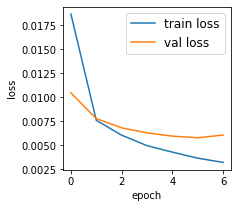

128


    Train loss: 0.010065640322864056
    Val loss: 0.0052001820877194405
    Train acc: 0.7002763373362445
    Val acc: 0.8246017156862745


    Train loss: 0.0036221102345734835
    Val loss: 0.002998215612024069
    Train acc: 0.8733795032751092
    Val acc: 0.8851102941176471


    Train loss: 0.002626595553010702
    Val loss: 0.0025289668701589108
    Train acc: 0.9049024290393013
    Val acc: 0.9021139705882353


    Train loss: 0.0021878022234886885
    Val loss: 0.0021368018351495266
    Train acc: 0.9195380731441049
    Val acc: 0.9136029411764706


    Train loss: 0.0024447529576718807
    Val loss: 0.002238764427602291
    Train acc: 0.9264976801310044
    Val acc: 0.9053308823529411


    Train loss: 0.0017241132445633411
    Val loss: 0.001824498875066638
    Train acc: 0.9315126910480349
    Val acc: 0.9217218137254902


    Train loss: 0.0015443115262314677
    Val loss: 0.0017122828867286444
    Train acc: 0.9399563318777293
    Val acc: 0.9260110294117647


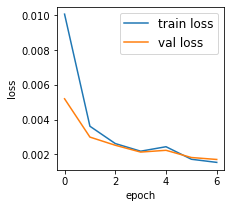

512


    Train loss: 0.00652357330545783
    Val loss: 0.006578005384653807
    Train acc: 0.03758491847826087
    Val acc: 0.043118990384615384


    Train loss: 0.006523314397782087
    Val loss: 0.006577978376299143
    Train acc: 0.03758491847826087
    Val acc: 0.043118990384615384


    Train loss: 0.006523399148136377
    Val loss: 0.0065782079473137856
    Train acc: 0.03758491847826087
    Val acc: 0.043118990384615384


    Train loss: 0.006523242220282555
    Val loss: 0.006578164175152779
    Train acc: 0.036599864130434784
    Val acc: 0.043118990384615384


    Train loss: 0.006523324642330408
    Val loss: 0.006578060798346996
    Train acc: 0.03770380434782609
    Val acc: 0.036508413461538464


    Train loss: 0.006523159332573414
    Val loss: 0.006578095722943544
    Train acc: 0.03833220108695652
    Val acc: 0.036508413461538464


    Train loss: 0.006523135583847761
    Val loss: 0.006578315515071154
    Train acc: 0.03833220108695652
    Val acc: 0.036508413461538464


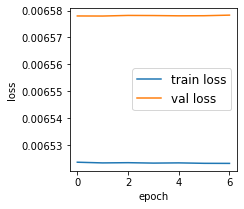

In [30]:
batch_sizes = [32, 128, 512]
gn_models = [ThreeLayersConvLettersModel(kernel_size1=5, kernel_size2=5, kernel_size3=3, out_channels1=30, out_channels2=50, out_channels3=100, bs=bs) for bs in batch_sizes]
for i in range(len(gn_models)):
    print(batch_sizes[i])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes[i], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_sizes[i], shuffle=True)
    optimizer = optim.SGD(gn_models[i].parameters(), lr=0.001, momentum=0.9)
    train(gn_models[i], criterion, optimizer, train_dataloader, val_dataloader, n_epochs=7)

In [ ]:
При увелиении batch_size модели с batch norm станеовятся хуже. Аналогичная ситуация с group_norm, к тому же при большом размере accuracy стало совсем грустно.

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

На трехслойной полносвязной модели вышло качество 88. (См. задание 1)

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

Я попросила своих друзей написать буквы, они прислали мне фотографии. Я перевела их в чб с помощью https://mass-images.pro/ru/batch/tpl/black-and-white, на что-то более умное не хватило времени (скорее всего не его:_)). Дальше в Paint я инвертировала цвета, изменила размер и положила все в папку. Попробовала прогнать модель с этими данными, но она мне выпюнола вердикт, что все мои катинки содержат с седе букуву "L". Сначала я не поняла, а потом как поняла! Поняла то, что картинки были сохранены не в формате .jpg, а .png. После исправления этого недопразумения, все буквы были детектированы верно!!!

In [72]:
def get_my_letters(path):
    X, y = [], []
    for root, dirs, files in os.walk(path):
        for filename in files:
            pic = plt.imread(f"{path}/{filename}")
            X.append(pic)
            y.append(ord(filename[0]) - ord('a'))
            plt.figure(figsize=(2,2))
            plt.imshow(pic)
            plt.show()
    return torch.tensor(X, dtype=torch.float), torch.tensor(y)
    

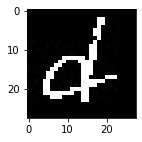

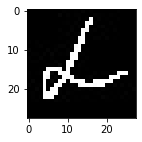

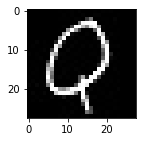

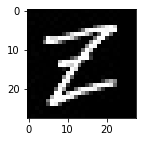

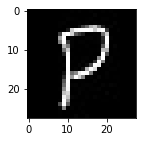

In [73]:
X, y = get_my_letters("Letters")

In [74]:
dataset = LettersDataset(X, y)

In [96]:
y_pred = best_3l_model(dataset.X.permute(0, 3, 1, 2))
pred_classes = torch.argmax(y_pred, dim=-1)

for idx in pred_classes:
    
    print(alphabet[idx])

d
l
q
z
p


**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.